<a href="https://colab.research.google.com/github/SicilianoBartolomeo/Human-activity-recognition/blob/main/HAR_Mhealth_DataSet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from operator import imod
import pandas as pd
import numpy as np
import tensorflow as tf
import keras as krs
from keras import Sequential
from keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPool2D, Conv1D, Bidirectional, LSTM
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import seaborn
from sklearn.model_selection import train_test_split
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler, RobustScaler

In [2]:
import random
seed=42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
from datetime import datetime


experiment_time = datetime.now().isoformat()
folder_name = str(experiment_time).replace(":","_")[0:19]
folder_name

configuration_file_name = 'configuration.txt'

In [12]:
dataset_path = 'MhealthDataset'
columns_names = ['user_id', 'activity', 'timestamp', 'x_axis', 'y_axis', 'z_axis']

In [4]:
X_column_names = ['x_axis','y_axis','z_axis']
y_column_name = 'activity'

In [5]:
classes_to_consider = ['StandingStill','SittingAndRelaxing',
     'LyingDown', 'Walking','ClimbingStairs', 'WaistBendsForward',
     'FrontalElevationOfArms','KneesBending','Cycling',
     'Jogging','Running','JumpFrontBack']

In [6]:
classes_to_rename = {
     1: 'StandingStill',
     2: 'SittingAndRelaxing',
     3: 'LyingDown',
     4: 'Walking',
     5: 'ClimbingStairs',
     6: 'WaistBendsForward',
     7: 'FrontalElevationOfArms',
     8: 'KneesBending',
     9: 'Cycling',
     10: 'Jogging',
     11: 'Running',
     12: 'JumpFrontBack',
     0: 'null'
}

In [9]:
time_steps_list = [600]
step_list =  [100]
use_magnitude = False
aggregate_falls = True
use_speed=False
use_total_speed=False
use_timestamp=False
use_squared_components=False
use_squared_speed=False
use_sign_speed=False
use_position=False

In [8]:
leave_one_subject_out = True
stratified_test_set = False
leave_one_subject_out_with_validation_users = False
bilstm_one_subject_out = True

use_stats_in_cnn=False

In [10]:
save_features = False

In [11]:
batchsize = 512

In [13]:
from os import mkdir
mkdir(folder_name)

In [14]:
config_file = open(folder_name + "/" + configuration_file_name,"a")
config_file.write("dataset: " + dataset_path +
"time_steps_list: " + str(time_steps_list) + 
"\nstep_list:" + str(step_list)+
"\nuse_magnitude: "+str(use_magnitude)+
"\naggregate_falls: "+str(aggregate_falls)+
"\nuse_speed: "+str(use_speed)+
"\nuse_total_speed: "+str(use_total_speed)+
"\nuse_timestamp: "+str(use_timestamp)+
"\nuse_squared_components: "+str(use_squared_components)+
"\nuse_squared_speed: "+str(use_squared_speed)+
"\nuse_sign_speed: "+str(use_sign_speed)+
"\nuse_position: "+str(use_position)
)
config_file.close()

# New dataset

In [15]:
import os
import pandas as pd
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/00319/MHEALTHDATASET.zip
!unzip MHEALTHDATASET.zip

--2023-02-01 15:04:28--  http://archive.ics.uci.edu/ml/machine-learning-databases/00319/MHEALTHDATASET.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75567983 (72M) [application/x-httpd-php]
Saving to: ‘MHEALTHDATASET.zip’

MHEALTHDATASET.zip  100%[===================>]  72.07M  78.9MB/s    in 0.9s    

2023-02-01 15:04:29 (78.9 MB/s) - ‘MHEALTHDATASET.zip’ saved [75567983/75567983]

Archive:  MHEALTHDATASET.zip
   creating: MHEALTHDATASET/
  inflating: MHEALTHDATASET/mHealth_subject1.log  
  inflating: MHEALTHDATASET/mHealth_subject10.log  
  inflating: MHEALTHDATASET/mHealth_subject2.log  
  inflating: MHEALTHDATASET/mHealth_subject3.log  
  inflating: MHEALTHDATASET/mHealth_subject4.log  
  inflating: MHEALTHDATASET/mHealth_subject5.log  
  inflating: MHEALTHDATASET/mHealth_subject6.log  
  inflating: MHEALTHDATASE

In [16]:
!cat MHEALTHDATASET/README.txt


*************************************************** mHealth dataset **********************************************************

Authors: Oresti Ba�os, Rafael Garcia, Alejandro Saez
Date: 22/10/2013
Institution: University of Granada (UGR) 
Department: Department of Computer Architecture and Computer Technology.
Contact: oresti@ugr.es (oresti.bl@gmail.com)

---------------------------------------------------------------------------------------------------------------------------------------------
NOTE: if you use this dataset please cite the following work

Banos, O., Garcia, R., Holgado-Terriza, J.A., Damas, M., Pomares, H., Rojas, I., Saez, A., Villalonga, C.: 
mHealthDroid: a novel framework for agile development of mobile health applications. 
In: Proceedings of the 6th International Work-conference on Ambient Assisted Living an Active Ageing (IWAAL 2014), Belfast, United Kingdom, December 2-5 (2014)

Insightful figures and descriptions are presented within this work.
-------------

In [17]:
for i in os.listdir('MHEALTHDATASET/'):
  if i not in ('README.txt'):
    print(i)

mHealth_subject10.log
mHealth_subject9.log
mHealth_subject6.log
mHealth_subject3.log
mHealth_subject8.log
mHealth_subject7.log
mHealth_subject2.log
mHealth_subject4.log
mHealth_subject1.log
mHealth_subject5.log


In [69]:
df = pd.DataFrame()
#loop to combine all data
for i in range(1,11):
    df1 = pd.read_csv(f'MHEALTHDATASET/mHealth_subject{i}.log', header=None, sep='\t')
    df1 = df1.loc[:, [14,15,16,23]]
    df1 = df1.rename(columns={
         14:"x_axis",15:"y_axis", 16:"z_axis", 23:"activity"
        })
    df1['user_id'] = i
    df = pd.concat([df,df1])

In [70]:
df = df.reset_index()
df['timestamp'] = df.index

In [71]:
df

,index,x_axis,y_axis,z_axis,activity,user_id,timestamp
0,0,-8.6499,-4.5781,0.187760,0,1,0
1,1,-8.6275,-4.3198,0.023595,0,1,1
2,2,-8.5055,-4.2772,0.275720,0,1,2
3,3,-8.6279,-4.3163,0.367520,0,1,3
4,4,-8.7008,-4.1459,0.407290,0,1,4
...,...,...,...,...,...,...,...
1215740,98299,-3.7198,-8.9071,0.294230,0,10,1215740
1215741,98300,-3.7160,-8.7455,0.448140,0,10,1215741
1215742,98301,-3.8824,-9.1155,0.450480,0,10,1215742
1215743,98302,-3.5564,-9.1441,0.594880,0,10,1215743


# Caricamento dati

In [ ]:
df = df.dropna()

In [30]:
df.isnull().sum()

index        0
x_axis       0
y_axis       0
z_axis       0
activity     0
user_id      0
timestamp    0
dtype: int64

In [31]:
df.head(10)

,index,x_axis,y_axis,z_axis,activity,user_id,timestamp
0,0,-8.6499,-4.5781,0.187760,0,1,0
1,1,-8.6275,-4.3198,0.023595,0,1,1
2,2,-8.5055,-4.2772,0.275720,0,1,2
3,3,-8.6279,-4.3163,0.367520,0,1,3
4,4,-8.7008,-4.1459,0.407290,0,1,4
5,5,-8.7247,-4.0449,0.506090,0,1,5
6,6,-9.0864,-4.1474,0.261380,0,1,6
7,7,-9.0143,-4.0052,0.476820,0,1,7
8,8,-9.0469,-4.0475,0.245540,0,1,8
9,9,-8.8318,-4.1090,0.096632,0,1,9


In [32]:
df.sample(10)

,index,x_axis,y_axis,z_axis,activity,user_id,timestamp
436857,22904,-2.5814,-9.7935,6.64570,0,4,436857
320977,29136,1.0325,-6.4693,2.07240,0,3,320977
798830,50029,-1.8696,-9.1629,2.70850,0,7,798830
115484,115484,-5.4885,-1.9806,7.94260,0,1,115484
212426,51146,-5.3706,-1.9832,7.68210,2,2,212426
673367,22870,-2.5923,-9.3613,1.86530,0,6,673367
864627,11378,-2.6751,-9.5033,-0.32933,1,8,864627
423422,9469,-7.5871,-3.6222,4.77720,0,4,423422
174690,13410,-2.1884,-17.4460,3.42980,0,2,174690
583972,53283,-8.1362,-13.1040,-0.42605,0,5,583972


In [33]:
df.describe()

,index,x_axis,y_axis,z_axis,activity,user_id,timestamp
count,1.215745e+06,1.215745e+06,1.215745e+06,1.215745e+06,1.215745e+06,1.215745e+06,1.215745e+06
mean,6.214424e+04,-3.713413e+00,-5.805526e+00,2.393880e+00,1.741465e+00,5.270370e+00,6.078720e+05
std,3.747980e+04,4.763586e+00,5.757639e+00,3.876503e+00,3.283679e+00,2.948526e+00,3.509555e+05
min,0.000000e+00,-2.236100e+01,-1.897200e+01,-1.823900e+01,0.000000e+00,1.000000e+00,0.000000e+00
25%,3.039300e+04,-6.076000e+00,-9.404200e+00,1.296500e-01,0.000000e+00,3.000000e+00,3.039360e+05
50%,6.078700e+04,-2.977600e+00,-7.461500e+00,1.928100e+00,0.000000e+00,5.000000e+00,6.078720e+05
75%,9.118000e+04,-1.193700e+00,-2.533900e+00,4.914700e+00,2.000000e+00,8.000000e+00,9.118080e+05
max,1.612790e+05,1.986400e+01,2.219100e+01,2.574100e+01,1.200000e+01,1.000000e+01,1.215744e+06


In [72]:
df['activity']=df['activity'].apply(lambda x: classes_to_rename[x] if x in classes_to_rename.keys() else x)

In [73]:
df = df[df['activity'].isin(classes_to_consider)]
df.reset_index(drop=True, inplace=True)

In [74]:
df['activity'].unique()

array(['StandingStill', 'SittingAndRelaxing', 'LyingDown', 'Walking',
       'WaistBendsForward', 'FrontalElevationOfArms', 'KneesBending',
       'Cycling', 'Jogging', 'Running', 'JumpFrontBack', 'ClimbingStairs'],
      dtype=object)

In [75]:
df.sample(10)

,index,x_axis,y_axis,z_axis,activity,user_id,timestamp
201685,59655,-8.71390,8.954800,0.47899,Running,6,710152
247922,21463,-9.58530,-0.054715,1.52850,LyingDown,8,874712
112501,45839,-1.43830,-7.239800,6.02340,SittingAndRelaxing,4,459792
69164,125178,0.88396,-7.735500,7.44660,Cycling,2,286458
133257,96803,2.41560,-7.467000,7.30370,Cycling,4,510756
225438,61136,-0.32131,-11.435000,-0.47799,WaistBendsForward,7,809937
178313,6024,-3.25380,-9.151600,1.84450,StandingStill,6,656521
80839,25493,-0.81338,-6.527100,0.28823,Walking,3,317334
83357,35793,-1.33950,-6.588200,0.18101,WaistBendsForward,3,327634
208955,11117,0.32809,-7.062500,1.75100,ClimbingStairs,7,759918


In [76]:
import math

if use_magnitude:
    df['magnitude'] = np.sqrt(np.power(df['x_axis'],2) + np.power(df['y_axis'],2) + np.power(df['z_axis'],2))
    X_column_names.append('magnitude')
df.sample(10)

,index,x_axis,y_axis,z_axis,activity,user_id,timestamp
15486,52862,-6.47840,-8.3959,1.41350,FrontalElevationOfArms,1,52862
110187,41221,-0.52626,-9.7820,0.80257,StandingStill,4,455174
284322,24531,-3.21990,6.6478,6.78030,LyingDown,9,1006804
130060,86079,-1.91100,-7.5478,2.21640,KneesBending,4,500032
19556,62564,-3.25790,-9.6153,1.46720,KneesBending,1,62564
25996,89177,-21.41300,-1.4276,2.24110,Jogging,1,89177
145429,8623,-8.50510,-4.8588,-0.87836,SittingAndRelaxing,5,539312
154290,25164,-1.32360,-9.6832,-2.31750,WaistBendsForward,5,555853
30769,101630,3.87770,-8.8763,-4.63130,Running,1,101630
186557,18876,-4.55160,-12.1190,3.09200,Walking,6,669373


In [77]:
classes = df['activity'].unique()
classes

array(['StandingStill', 'SittingAndRelaxing', 'LyingDown', 'Walking',
       'WaistBendsForward', 'FrontalElevationOfArms', 'KneesBending',
       'Cycling', 'Jogging', 'Running', 'JumpFrontBack', 'ClimbingStairs'],
      dtype=object)

In [ ]:
if use_speed:
    records = []

    for index, row in df.iterrows():
        record = dict()
        if index==0 or (row['activity'])!=(df.iloc[index-1]['activity']):
            record['id']=index
            record['timestamp']=row['timestamp']
            record['v_x']=0
            record['v_y']=0
            record['v_z']=0
            record['x']=0
            record['y']=0
            record['z']=0
            record['v']=0
        else:
            prev_row = df.iloc[index-1]
            prev_record = records[-1]
            delta_t=(float(row['timestamp'])-float(prev_row['timestamp']))/1000
            record['id']=index
            record['timestamp']=row['timestamp']
            vx=float(prev_record['v_x'])+float(prev_row['x_axis'])*delta_t
            vy=float(prev_record['v_y'])+float(prev_row['y_axis'])*delta_t
            vz=float(prev_record['v_z'])+float(prev_row['z_axis'])*delta_t
            record['v_x']=vx
            record['v_y']=vy
            record['v_z']=vz
            x = float(prev_record['x']) + float(prev_record['v_x'])*delta_t + 0.5*float(prev_row['x_axis'])*(delta_t*delta_t)
            y = float(prev_record['x']) + float(prev_record['v_y'])*delta_t + 0.5*float(prev_row['y_axis'])*(delta_t*delta_t)
            z = float(prev_record['x']) + float(prev_record['v_z'])*delta_t + 0.5*float(prev_row['z_axis'])*(delta_t*delta_t)
            record['x']=x
            record['y']=y
            record['z']=z
            record['v']=np.sqrt(np.power(vx,2) + np.power(vy,2) + np.power(vz,2))
        records.append(record)

    df_velocità = pd.DataFrame(records, columns=['id','v_x','v_y','v_z','v','x','y','z'])
    df = pd.concat([df, df_velocità], axis=1).drop(columns=['id'])
    X_column_names+=['v_x','v_y','v_z','v']
    if not use_total_speed:
        X_column_names.remove('v')
    if use_position:
        X_column_names+=['x','y','z']
    df_velocità.head()

In [39]:
df.head()

,index,x_axis,y_axis,z_axis,activity,user_id,timestamp
0,6656,-2.8439,-9.0618,1.8177,StandingStill,1,6656
1,6657,-2.9935,-9.2048,1.5189,StandingStill,1,6657
2,6658,-2.8846,-9.1945,1.5507,StandingStill,1,6658
3,6659,-2.9245,-9.1746,1.5413,StandingStill,1,6659
4,6660,-2.8963,-9.2039,1.6127,StandingStill,1,6660


In [ ]:
if use_squared_components:
    df['x_axis_squared'] = np.square(df['x_axis'])
    df['y_axis_squared'] = np.square(df['y_axis'])
    df['z_axis_squared'] = np.square(df['z_axis'])
    X_column_names+=['x_axis_squared', 'y_axis_squared','z_axis_squared']

if use_squared_speed:
    df['vx2'] = np.square(df['v_x'])
    df['vy2'] = np.square(df['v_y'])
    df['vz2'] = np.square(df['v_z'])
    X_column_names+=['vx2','vy2','vz2']

if use_sign_speed:
    df['signvx']= np.sign(df['v_x'])  #df['v_x']/(np.abs(df['v_x'])+1)
    df['signvy']= np.sign(df['v_y'])  #df['v_y']/(np.abs(df['v_y'])+1)
    df['signvz']= np.sign(df['v_z'])  #df['v_z']/(np.abs(df['v_z'])+1)
    X_column_names+=['signvx','signvy','signvz']

In [78]:
users_ids = df['user_id'].unique()
users_number = len(users_ids)
print("Numero totale di utenti:",users_number)

Numero totale di utenti: 10


In [79]:
user_original_data = dict() #dict {user_id: dataframe_dati_utente_originali}
for users_id in users_ids:
    user_original_data[users_id]=df[df['user_id']==users_id]

In [80]:
user_original_data.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [43]:
user_original_data[1]

,index,x_axis,y_axis,z_axis,activity,user_id,timestamp
0,6656,-2.8439,-9.0618,1.81770,StandingStill,1,6656
1,6657,-2.9935,-9.2048,1.51890,StandingStill,1,6657
2,6658,-2.8846,-9.1945,1.55070,StandingStill,1,6658
3,6659,-2.9245,-9.1746,1.54130,StandingStill,1,6659
4,6660,-2.8963,-9.2039,1.61270,StandingStill,1,6660
...,...,...,...,...,...,...,...
35169,160251,-2.3478,-9.4027,-1.27220,ClimbingStairs,1,160251
35170,160252,-1.9978,-9.4592,-0.92088,ClimbingStairs,1,160252
35171,160253,-1.9755,-8.8985,-0.85118,ClimbingStairs,1,160253
35172,160254,-2.2332,-8.8793,-0.93355,ClimbingStairs,1,160254


In [81]:
from scipy import stats
def create_sliding_windows(data, time_steps=1, step=1):
  Xs = []
  for i in range(0, len(data) - time_steps, step):
    v = data.iloc[i: (i+time_steps)]
    

    Xs.append(v)
    
  return Xs

In [82]:
user_trials = dict() #dict {user id: lista di trial dell'utente}

for users_id in users_ids:
    original_data = user_original_data[users_id]
    original_data.reset_index(inplace=True)
    #troviamo gli indici dei record iniziale di ogni trial (timestamp=0)
    index_start_trial = [0]
    for index, row in original_data.iterrows():
        if index==0:
            continue
        #if int(row['activity'])!=int(original_data.iloc[index-1]['activity']):
        if (row['activity'])!=(original_data.iloc[index-1]['activity']):
           # print("ok")
            index_start_trial.append(index)
    trials = []
    for i in range(len(index_start_trial)-1):
        trials.append(original_data.iloc[index_start_trial[i]:index_start_trial[i+1]-1])
    trials.append(original_data.iloc[index_start_trial[len(index_start_trial)-1]:])
    user_trials[users_id]=trials

In [46]:
user_trials[3][2]

,level_0,index,x_axis,y_axis,z_axis,activity,user_id,timestamp
6144,76850,16384,-3.9965,4.5835,8.3542,LyingDown,3,308225
6145,76851,16385,-4.1338,4.6524,8.2430,LyingDown,3,308226
6146,76852,16386,-3.6495,4.6610,8.0976,LyingDown,3,308227
6147,76853,16387,-3.2419,4.7016,8.1622,LyingDown,3,308228
6148,76854,16388,-3.2217,4.7912,8.1250,LyingDown,3,308229
...,...,...,...,...,...,...,...,...
9210,79916,19450,-3.0977,4.2550,7.5044,LyingDown,3,311291
9211,79917,19451,-3.3450,4.5365,7.6539,LyingDown,3,311292
9212,79918,19452,-3.3622,4.7283,7.8302,LyingDown,3,311293
9213,79919,19453,-3.3038,4.7288,7.8823,LyingDown,3,311294


In [47]:
user_trials[1][4]

,level_0,index,x_axis,y_axis,z_axis,activity,user_id,timestamp
12288,12288,37376,-5.6556,-8.2373,3.2652,WaistBendsForward,1,37376
12289,12289,37377,-4.7974,-8.4328,2.7242,WaistBendsForward,1,37377
12290,12290,37378,-3.5484,-8.1866,2.3407,WaistBendsForward,1,37378
12291,12291,37379,-2.1877,-7.5955,1.4536,WaistBendsForward,1,37379
12292,12292,37380,-2.3839,-7.0219,1.8052,WaistBendsForward,1,37380
...,...,...,...,...,...,...,...,...
15354,15354,40442,-2.8090,-9.2960,1.3998,WaistBendsForward,1,40442
15355,15355,40443,-2.9998,-9.3622,1.7819,WaistBendsForward,1,40443
15356,15356,40444,-2.7318,-9.4944,1.5565,WaistBendsForward,1,40444
15357,15357,40445,-2.7539,-9.4472,1.2776,WaistBendsForward,1,40445


In [83]:
sliding_w_by_timestep=dict() #[timestep][steps][userid][indice trial][indice sliding window]

for time_steps in time_steps_list:
    sliding_w_by_step=dict()
    for step in step_list:
        user_sliding_windows = dict()  #[userid][indice trial][indice sliding window]
        for user_id in users_ids:
            user_trial_list = user_trials[user_id]
            num_trials = len(user_trial_list)  
            list_sliding_windows = []  
            for i in range(num_trials):
                trial = user_trial_list[i]
                sliding_window = create_sliding_windows(trial, time_steps, step)
                list_sliding_windows.append(sliding_window)
            user_sliding_windows[user_id]=list_sliding_windows    
        sliding_w_by_step[step]=user_sliding_windows
    sliding_w_by_timestep[time_steps]=sliding_w_by_step  

In [49]:
trial

,level_0,index,x_axis,y_axis,z_axis,activity,user_id,timestamp
32666,342171,95181,-1.48750,-0.38290,-0.289980,JumpFrontBack,10,1212622
32667,342172,95182,-1.67190,-0.78675,0.325250,JumpFrontBack,10,1212623
32668,342173,95183,-0.49839,-1.52550,0.454980,JumpFrontBack,10,1212624
32669,342174,95184,0.32067,-2.25940,0.064115,JumpFrontBack,10,1212625
32670,342175,95185,-0.50649,-1.41980,1.022800,JumpFrontBack,10,1212626
...,...,...,...,...,...,...,...,...
33685,343190,96200,-8.23480,-4.96520,2.480900,JumpFrontBack,10,1213641
33686,343191,96201,-21.31800,-10.21300,3.656000,JumpFrontBack,10,1213642
33687,343192,96202,-21.29700,-18.70500,4.460600,JumpFrontBack,10,1213643
33688,343193,96203,-21.13800,-18.69800,1.158800,JumpFrontBack,10,1213644


In [50]:
sliding_w_by_timestep[time_steps_list[0]][step_list[0]][1][0][0]

,level_0,index,x_axis,y_axis,z_axis,activity,user_id,timestamp
0,0,6656,-2.8439,-9.0618,1.8177,StandingStill,1,6656
1,1,6657,-2.9935,-9.2048,1.5189,StandingStill,1,6657
2,2,6658,-2.8846,-9.1945,1.5507,StandingStill,1,6658
3,3,6659,-2.9245,-9.1746,1.5413,StandingStill,1,6659
4,4,6660,-2.8963,-9.2039,1.6127,StandingStill,1,6660
...,...,...,...,...,...,...,...,...
595,595,7251,-2.9564,-8.9846,1.5404,StandingStill,1,7251
596,596,7252,-3.0286,-9.1732,1.6768,StandingStill,1,7252
597,597,7253,-3.0265,-9.1640,1.6043,StandingStill,1,7253
598,598,7254,-3.0468,-9.0044,1.5602,StandingStill,1,7254


In [84]:
df_aggregate_feature_by_timestep = dict()
axes = ['x_axis','y_axis','z_axis']

for time_steps in time_steps_list:
    df_aggregate_feature_by_step = dict()
    for step in step_list:
        df_aggregate_feature_by_user = []
        for user_id in users_ids:
            df_aggregate_feature_by_trial=dict()
            for trial in range(len(sliding_w_by_timestep[time_steps][step][user_id])):
                df_aggregate_feature_by_sliding_window = dict()
                for sliding_window in range(len(sliding_w_by_timestep[time_steps][step][user_id][trial])):
                    tupla = dict()
                    tupla['time_steps']=time_steps
                    tupla['step']=step
                    tupla['user_id']=user_id
                    tupla['trial']=trial
                    tupla['sliding_window']=sliding_window
                    tupla['activity']=sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window]['activity'].unique()[0]
                    
                    for axis in axes:
                        tupla[f'{axis}_mean']=sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][axis].mean()
                        tupla[f'{axis}_devstd']=sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][axis].std()
                        tupla[f'{axis}_power']=sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][axis].pow(2).mean()                   
                    
                    
                    for k1, v1 in sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][axes].cov().to_dict().items():
                        for k2, v2 in v1.items():
                            tupla[f"cov({k1},{k2})"]=v2

                    df_aggregate_feature_by_user.append(tupla)
                    
                    #df_aggregate_feature_by_sliding_window[sliding_window]=tupla
                #df_aggregate_feature_by_trial[trial]=df_aggregate_feature_by_sliding_window
            #df_aggregate_feature_by_user[user_id]=df_aggregate_feature_by_trial
        df_aggregate_feature_by_step[step]=pd.DataFrame(df_aggregate_feature_by_user)
    df_aggregate_feature_by_timestep[time_steps]=df_aggregate_feature_by_step


In [52]:
df_aggregate_feature_by_timestep[time_steps_list[0]][step_list[0]]

,time_steps,step,user_id,trial,sliding_window,activity,x_axis_mean,x_axis_devstd,x_axis_power,y_axis_mean,...,z_axis_power,"cov(x_axis,x_axis)","cov(x_axis,y_axis)","cov(x_axis,z_axis)","cov(y_axis,x_axis)","cov(y_axis,y_axis)","cov(y_axis,z_axis)","cov(z_axis,x_axis)","cov(z_axis,y_axis)","cov(z_axis,z_axis)"
0,600,100,1,0,0,StandingStill,-2.913919,0.124591,8.506421,-9.137065,...,2.927027,0.015523,-0.002366,0.000483,-0.002366,0.010738,0.001293,0.000483,0.001293,0.013734
1,600,100,1,0,1,StandingStill,-2.934854,0.125581,8.629111,-9.131949,...,2.860133,0.015771,-0.002199,0.000220,-0.002199,0.010486,0.001547,0.000220,0.001547,0.014671
2,600,100,1,0,2,StandingStill,-2.956434,0.126773,8.756545,-9.129857,...,2.800738,0.016071,-0.001912,-0.000358,-0.001912,0.010785,0.002101,-0.000358,0.002101,0.013891
3,600,100,1,0,3,StandingStill,-2.969162,0.118665,8.829979,-9.132843,...,2.726334,0.014081,-0.001624,0.000299,-0.001624,0.010794,0.001464,0.000299,0.001464,0.012247
4,600,100,1,0,4,StandingStill,-2.997320,0.111062,8.996243,-9.129314,...,2.670609,0.012335,-0.000886,-0.000209,-0.000886,0.010501,0.001453,-0.000209,0.001453,0.012284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2750,600,100,10,11,0,JumpFrontBack,-6.635264,9.466314,133.488480,-4.512021,...,16.584951,89.611110,59.199037,-27.808903,59.199037,45.909004,-18.935020,-27.808903,-18.935020,12.690763
2751,600,100,10,11,1,JumpFrontBack,-6.476325,9.507916,132.192587,-4.143591,...,17.964854,90.400474,56.796421,-29.945796,56.796421,42.401329,-19.426219,-29.945796,-19.426219,13.922693
2752,600,100,10,11,2,JumpFrontBack,-6.393348,9.676111,134.345971,-4.154254,...,19.430631,93.627119,58.608675,-31.712160,58.608675,43.688705,-20.814367,-31.712160,-20.814367,15.110421
2753,600,100,10,11,3,JumpFrontBack,-6.129782,9.661786,130.768752,-3.921195,...,20.100687,93.350109,58.039478,-32.593311,58.039478,43.217231,-21.556425,-32.593311,-21.556425,15.770622


In [85]:
import itertools

if save_features:
    for config in itertools.product(time_steps_list, step_list):
        time_step = config[0]
        step = config[1]
        
        example_list = []
        data = sliding_w_by_timestep[time_step][step]
        for user_id in users_ids:
            for trial in range(len(data[user_id])):
                for sliding_window in range(len(data[user_id][trial])):
                    for index, row in data[user_id][trial][sliding_window].iterrows():
                        item = row.to_dict()
                        item.update({'trial':trial,'sliding_window':sliding_window})
                        example_list.append(item)
        example_df = pd.DataFrame(example_list, columns=['trial','sliding_window']+list(sliding_w_by_timestep[time_step][step][users_ids[0]][0][0].columns))
        example_df.drop(columns="index", inplace=True)
        example_df.to_csv(f"{dataset_path.split('.')[0]}_{time_step}_{step}.csv")

In [86]:
tuple_by_timestep=dict()
for time_steps in time_steps_list:
    tuple_by_step=dict()
    for step in step_list:
        tuple = dict()

        for user_id in users_ids:
            Xs = []
            ys = []
            for trial in range(len(sliding_w_by_timestep[time_steps][step][user_id])):
                for sliding_window in range(len(sliding_w_by_timestep[time_steps][step][user_id][trial])):
                    Xs.append(np.array(sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][X_column_names]))
                    ys.append(np.array(sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][y_column_name].unique()))
            tuple[user_id]=(Xs,ys)
        tuple_by_step[step]=tuple
    tuple_by_timestep[time_steps]=tuple_by_step        

In [87]:
ignore_columns = ['time_steps', 'step', 'user_id', 'trial', 'activity', 'sliding_window']

tuple_by_timestep_with_stats=dict()
for time_steps in time_steps_list:
    tuple_by_step=dict()
    for step in step_list:
        tuple = dict()
        actual_df_stats = df_aggregate_feature_by_timestep[time_steps][step]
        feature_columns = [col_name for col_name in list(actual_df_stats.columns.values) if not col_name in ignore_columns]
        for user_id in users_ids:
            Xs = []
            ys = []
            for trial in range(len(sliding_w_by_timestep[time_steps][step][user_id])):
                for sliding_window in range(len(sliding_w_by_timestep[time_steps][step][user_id][trial])):
                    raw_and_feature = np.array(sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][X_column_names]).flatten().reshape(-1,1)
                    actual_row_stats = actual_df_stats.loc[(actual_df_stats['time_steps']==time_steps) & (actual_df_stats['step']==step) & (actual_df_stats['user_id']==user_id) & (actual_df_stats['trial']==trial) &(actual_df_stats['sliding_window']==sliding_window)]
                    aggregate_feature = np.array(actual_row_stats[feature_columns]).reshape(-1,1)
                    #aggregate_feature = np.array(list(df_aggregate_feature_by_timestep[time_steps][step][user_id][trial][sliding_window].values())[2:]).reshape(-1,1)
                    Xs.append(np.concatenate((raw_and_feature,aggregate_feature),axis=0))
                    ys.append(np.array(sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][y_column_name].unique()))
            tuple[user_id]=(Xs,ys)
        tuple_by_step[step]=tuple
    tuple_by_timestep_with_stats[time_steps]=tuple_by_step     

In [56]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives/ (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
    
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# CNN

In [57]:
cnn_dir = folder_name + "\\cnn"
leave_one_subject_out_dir = "\\leave_one_subject_out"
leave_one_subject_out_with_validation_user_dir =  "\\leave_one_subject_out_with_validation_user"
stratified_dir = "\\stratified"
plot_dir = "\\plot"
result_filename = "\\result.csv"
config_filename = "\\config.txt"

mkdir(cnn_dir )


In [58]:
def createCNN(input_size, output_size):
    model = Sequential()
    model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape = input_size))
    model.add(Dropout(0.5))
    model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu'))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax'))
    model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['accuracy',f1_m])

    cnn_config_file = open(cnn_dir+config_filename, "a")
    model.summary(print_fn=lambda x: cnn_config_file.write(x))
    cnn_config_file.close()
    
    return model

In [59]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc = enc.fit(np.array(classes).reshape(-1,1))

In [60]:
import gc
gc.collect()

0

In [61]:
if use_stats_in_cnn:
    data_cnn = tuple_by_timestep_with_stats
else:
    data_cnn = tuple_by_timestep

## CNN - Leave One Subject Out

600 100
Utente test:  1
Training: x-> 1977 y-> 1977
Validation: x-> 495 y-> 495
Testing: x-> 283 y-> 283
Total: x-> 2755 y-> 2755
Epoch 1/100
16/16 [==============================] - 10s 66ms/step - loss: 2.3080 - accuracy: 0.1755 - f1_m: 0.0644 - val_loss: 2.0514 - val_accuracy: 0.2768 - val_f1_m: 0.0000e+00
Epoch 2/100
16/16 [==============================] - 1s 34ms/step - loss: 1.7483 - accuracy: 0.3384 - f1_m: 0.3064 - val_loss: 1.4718 - val_accuracy: 0.5010 - val_f1_m: 0.3922
Epoch 3/100
16/16 [==============================] - 1s 34ms/step - loss: 1.3817 - accuracy: 0.5003 - f1_m: 0.4580 - val_loss: 1.1902 - val_accuracy: 0.5475 - val_f1_m: 0.5021
Epoch 4/100
16/16 [==============================] - 1s 33ms/step - loss: 1.1290 - accuracy: 0.5635 - f1_m: 0.5376 - val_loss: 1.0152 - val_accuracy: 0.6384 - val_f1_m: 0.5554
Epoch 5/100
16/16 [==============================] - 1s 35ms/step - loss: 0.9231 - accuracy: 0.6520 - f1_m: 0.6128 - val_loss: 0.7995 - val_accuracy: 0.7091 - va

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


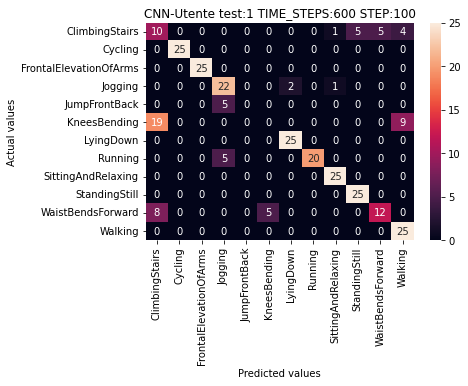

Utente test:  2
Training: x-> 1973 y-> 1973
Validation: x-> 494 y-> 494
Testing: x-> 288 y-> 288
Total: x-> 2755 y-> 2755
Epoch 1/100
16/16 [==============================] - 2s 66ms/step - loss: 2.4306 - accuracy: 0.1647 - f1_m: 0.0526 - val_loss: 2.1755 - val_accuracy: 0.2105 - val_f1_m: 0.0000e+00
Epoch 2/100
16/16 [==============================] - 1s 32ms/step - loss: 1.9064 - accuracy: 0.2686 - f1_m: 0.2385 - val_loss: 1.7767 - val_accuracy: 0.3522 - val_f1_m: 0.1718
Epoch 3/100
16/16 [==============================] - 1s 34ms/step - loss: 1.5854 - accuracy: 0.4055 - f1_m: 0.4127 - val_loss: 1.4992 - val_accuracy: 0.4251 - val_f1_m: 0.3872
Epoch 4/100
16/16 [==============================] - 1s 33ms/step - loss: 1.3549 - accuracy: 0.5003 - f1_m: 0.5041 - val_loss: 1.3206 - val_accuracy: 0.5061 - val_f1_m: 0.4602
Epoch 5/100
16/16 [==============================] - 1s 33ms/step - loss: 1.1451 - accuracy: 0.5641 - f1_m: 0.5525 - val_loss: 1.0280 - val_accuracy: 0.5769 - val_f1_m: 0

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


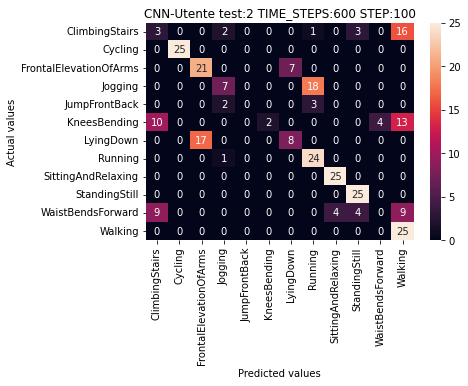

Utente test:  3
Training: x-> 1975 y-> 1975
Validation: x-> 494 y-> 494
Testing: x-> 286 y-> 286
Total: x-> 2755 y-> 2755
Epoch 1/100
16/16 [==============================] - 1s 60ms/step - loss: 2.0521 - accuracy: 0.2466 - f1_m: 0.1600 - val_loss: 1.5334 - val_accuracy: 0.4474 - val_f1_m: 0.3565
Epoch 2/100
16/16 [==============================] - 1s 33ms/step - loss: 1.4357 - accuracy: 0.4597 - f1_m: 0.4234 - val_loss: 1.2032 - val_accuracy: 0.5223 - val_f1_m: 0.4344
Epoch 3/100
16/16 [==============================] - 1s 35ms/step - loss: 1.1805 - accuracy: 0.5159 - f1_m: 0.4823 - val_loss: 1.0231 - val_accuracy: 0.5526 - val_f1_m: 0.5212
Epoch 4/100
16/16 [==============================] - 1s 35ms/step - loss: 0.9742 - accuracy: 0.6041 - f1_m: 0.5795 - val_loss: 0.8232 - val_accuracy: 0.6761 - val_f1_m: 0.6649
Epoch 5/100
16/16 [==============================] - 1s 34ms/step - loss: 0.8118 - accuracy: 0.6759 - f1_m: 0.6700 - val_loss: 0.7997 - val_accuracy: 0.6802 - val_f1_m: 0.667

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


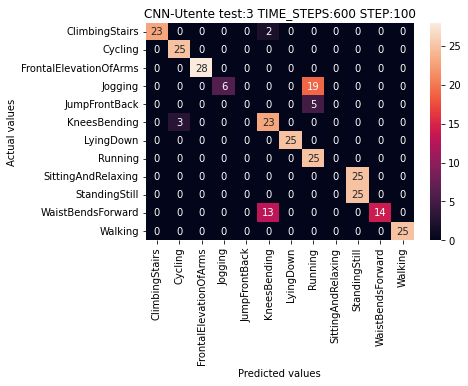

Utente test:  4
Training: x-> 1975 y-> 1975
Validation: x-> 494 y-> 494
Testing: x-> 286 y-> 286
Total: x-> 2755 y-> 2755
Epoch 1/100
16/16 [==============================] - 1s 51ms/step - loss: 2.1208 - accuracy: 0.2081 - f1_m: 0.1628 - val_loss: 1.8174 - val_accuracy: 0.2227 - val_f1_m: 0.1996
Epoch 2/100
16/16 [==============================] - 1s 34ms/step - loss: 1.5570 - accuracy: 0.3904 - f1_m: 0.3967 - val_loss: 1.3747 - val_accuracy: 0.4636 - val_f1_m: 0.3997
Epoch 3/100
16/16 [==============================] - 1s 37ms/step - loss: 1.2796 - accuracy: 0.5089 - f1_m: 0.4808 - val_loss: 1.1811 - val_accuracy: 0.5486 - val_f1_m: 0.4884
Epoch 4/100
16/16 [==============================] - 1s 36ms/step - loss: 1.0467 - accuracy: 0.5878 - f1_m: 0.5702 - val_loss: 1.0004 - val_accuracy: 0.6275 - val_f1_m: 0.5714
Epoch 5/100
16/16 [==============================] - 1s 36ms/step - loss: 0.8854 - accuracy: 0.6668 - f1_m: 0.6290 - val_loss: 0.8638 - val_accuracy: 0.6538 - val_f1_m: 0.658

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


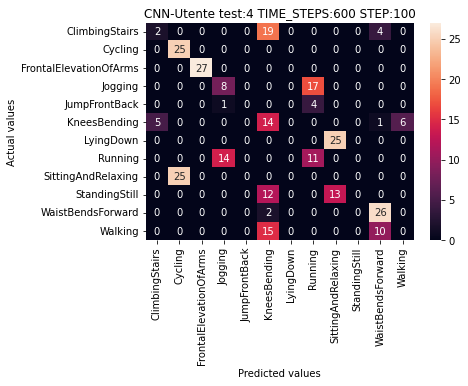

Utente test:  5
Training: x-> 1986 y-> 1986
Validation: x-> 497 y-> 497
Testing: x-> 272 y-> 272
Total: x-> 2755 y-> 2755
Epoch 1/100
16/16 [==============================] - 2s 71ms/step - loss: 2.0891 - accuracy: 0.2130 - f1_m: 0.1569 - val_loss: 1.7294 - val_accuracy: 0.2736 - val_f1_m: 0.3168
Epoch 2/100
16/16 [==============================] - 1s 35ms/step - loss: 1.5321 - accuracy: 0.4139 - f1_m: 0.3832 - val_loss: 1.2706 - val_accuracy: 0.4889 - val_f1_m: 0.4497
Epoch 3/100
16/16 [==============================] - 1s 34ms/step - loss: 1.2113 - accuracy: 0.5176 - f1_m: 0.4946 - val_loss: 1.0669 - val_accuracy: 0.5573 - val_f1_m: 0.5264
Epoch 4/100
16/16 [==============================] - 1s 35ms/step - loss: 1.0560 - accuracy: 0.5775 - f1_m: 0.5417 - val_loss: 0.9871 - val_accuracy: 0.6137 - val_f1_m: 0.5508
Epoch 5/100
16/16 [==============================] - 1s 34ms/step - loss: 0.9495 - accuracy: 0.6213 - f1_m: 0.6198 - val_loss: 0.8117 - val_accuracy: 0.7103 - val_f1_m: 0.665

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


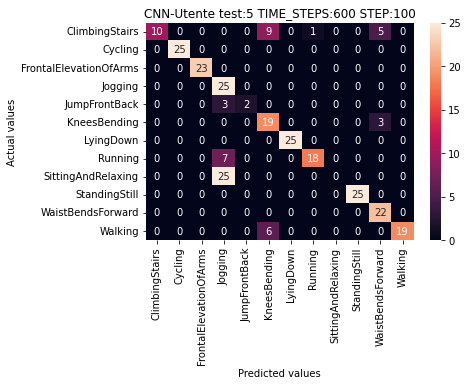

Utente test:  6
Training: x-> 2000 y-> 2000
Validation: x-> 500 y-> 500
Testing: x-> 255 y-> 255
Total: x-> 2755 y-> 2755
Epoch 1/100
16/16 [==============================] - 2s 72ms/step - loss: 2.1491 - accuracy: 0.2070 - f1_m: 0.1352 - val_loss: 1.7880 - val_accuracy: 0.4080 - val_f1_m: 0.0922
Epoch 2/100
16/16 [==============================] - 1s 35ms/step - loss: 1.5208 - accuracy: 0.4340 - f1_m: 0.4058 - val_loss: 1.2804 - val_accuracy: 0.5260 - val_f1_m: 0.4351
Epoch 3/100
16/16 [==============================] - 1s 35ms/step - loss: 1.1815 - accuracy: 0.5320 - f1_m: 0.5104 - val_loss: 0.9895 - val_accuracy: 0.5820 - val_f1_m: 0.5642
Epoch 4/100
16/16 [==============================] - 1s 37ms/step - loss: 0.9995 - accuracy: 0.6300 - f1_m: 0.5736 - val_loss: 0.8138 - val_accuracy: 0.6820 - val_f1_m: 0.6834
Epoch 5/100
16/16 [==============================] - 1s 37ms/step - loss: 0.8209 - accuracy: 0.6855 - f1_m: 0.6643 - val_loss: 0.6771 - val_accuracy: 0.7060 - val_f1_m: 0.719

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


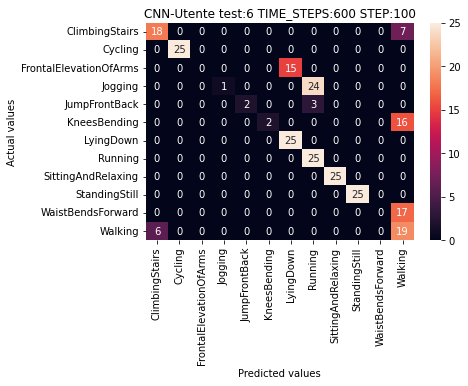

Utente test:  7
Training: x-> 1984 y-> 1984
Validation: x-> 496 y-> 496
Testing: x-> 275 y-> 275
Total: x-> 2755 y-> 2755
Epoch 1/100
16/16 [==============================] - 2s 80ms/step - loss: 2.2230 - accuracy: 0.1946 - f1_m: 0.1149 - val_loss: 1.8338 - val_accuracy: 0.2560 - val_f1_m: 0.2592
Epoch 2/100
16/16 [==============================] - 1s 36ms/step - loss: 1.6389 - accuracy: 0.3690 - f1_m: 0.3382 - val_loss: 1.3227 - val_accuracy: 0.4919 - val_f1_m: 0.4149
Epoch 3/100
16/16 [==============================] - 1s 36ms/step - loss: 1.3171 - accuracy: 0.4788 - f1_m: 0.4334 - val_loss: 1.0824 - val_accuracy: 0.6593 - val_f1_m: 0.5281
Epoch 4/100
16/16 [==============================] - 1s 34ms/step - loss: 1.1250 - accuracy: 0.5549 - f1_m: 0.5374 - val_loss: 0.9057 - val_accuracy: 0.6895 - val_f1_m: 0.5831
Epoch 5/100
16/16 [==============================] - 1s 36ms/step - loss: 0.9428 - accuracy: 0.6356 - f1_m: 0.6085 - val_loss: 0.8534 - val_accuracy: 0.6593 - val_f1_m: 0.636

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


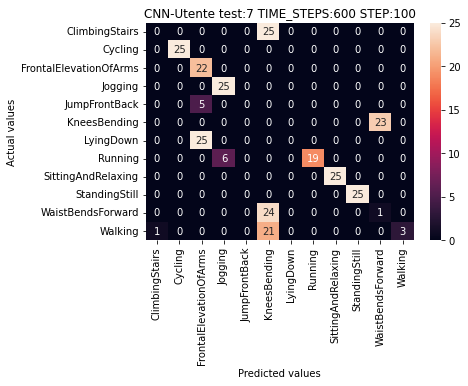

Utente test:  8
Training: x-> 1991 y-> 1991
Validation: x-> 498 y-> 498
Testing: x-> 266 y-> 266
Total: x-> 2755 y-> 2755
Epoch 1/100
16/16 [==============================] - 2s 70ms/step - loss: 2.0725 - accuracy: 0.2290 - f1_m: 0.1511 - val_loss: 1.6480 - val_accuracy: 0.4217 - val_f1_m: 0.1668
Epoch 2/100
16/16 [==============================] - 1s 35ms/step - loss: 1.4277 - accuracy: 0.4726 - f1_m: 0.4158 - val_loss: 1.2659 - val_accuracy: 0.5442 - val_f1_m: 0.4190
Epoch 3/100
16/16 [==============================] - 1s 37ms/step - loss: 1.1927 - accuracy: 0.5254 - f1_m: 0.5016 - val_loss: 1.1119 - val_accuracy: 0.5482 - val_f1_m: 0.5314
Epoch 4/100
16/16 [==============================] - 1s 34ms/step - loss: 1.0386 - accuracy: 0.5811 - f1_m: 0.5447 - val_loss: 0.9988 - val_accuracy: 0.5743 - val_f1_m: 0.5807
Epoch 5/100
16/16 [==============================] - 1s 36ms/step - loss: 0.8589 - accuracy: 0.6650 - f1_m: 0.6377 - val_loss: 0.9437 - val_accuracy: 0.6044 - val_f1_m: 0.623

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


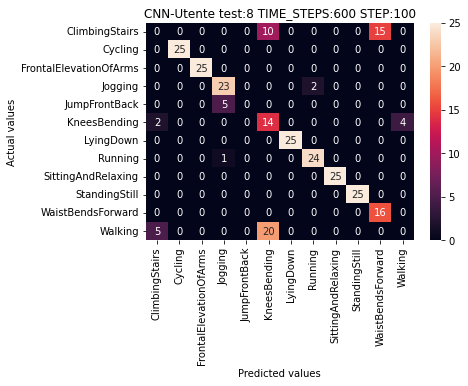

Utente test:  9
Training: x-> 1984 y-> 1984
Validation: x-> 496 y-> 496
Testing: x-> 275 y-> 275
Total: x-> 2755 y-> 2755
Epoch 1/100
16/16 [==============================] - 1s 54ms/step - loss: 2.2202 - accuracy: 0.1865 - f1_m: 0.0724 - val_loss: 1.9082 - val_accuracy: 0.3609 - val_f1_m: 0.0077
Epoch 2/100
16/16 [==============================] - 1s 35ms/step - loss: 1.6650 - accuracy: 0.3730 - f1_m: 0.2851 - val_loss: 1.4627 - val_accuracy: 0.4677 - val_f1_m: 0.2296
Epoch 3/100
16/16 [==============================] - 1s 35ms/step - loss: 1.3514 - accuracy: 0.4708 - f1_m: 0.4031 - val_loss: 1.1869 - val_accuracy: 0.5484 - val_f1_m: 0.3680
Epoch 4/100
16/16 [==============================] - 1s 35ms/step - loss: 1.1287 - accuracy: 0.5655 - f1_m: 0.4959 - val_loss: 0.9838 - val_accuracy: 0.6270 - val_f1_m: 0.5305
Epoch 5/100
16/16 [==============================] - 1s 34ms/step - loss: 0.9672 - accuracy: 0.6321 - f1_m: 0.5936 - val_loss: 0.8590 - val_accuracy: 0.6391 - val_f1_m: 0.663

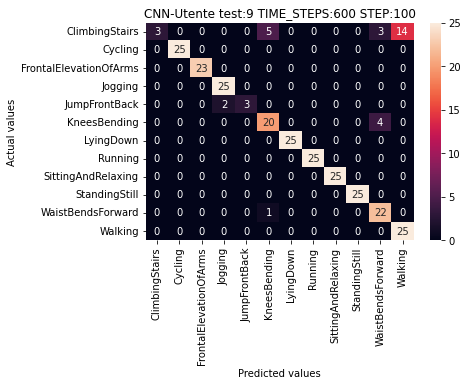

Utente test:  10
Training: x-> 1988 y-> 1988
Validation: x-> 498 y-> 498
Testing: x-> 269 y-> 269
Total: x-> 2755 y-> 2755
Epoch 1/100
16/16 [==============================] - 2s 65ms/step - loss: 2.1467 - accuracy: 0.2123 - f1_m: 0.1314 - val_loss: 1.8216 - val_accuracy: 0.3373 - val_f1_m: 0.2183
Epoch 2/100
16/16 [==============================] - 1s 35ms/step - loss: 1.6484 - accuracy: 0.3813 - f1_m: 0.4001 - val_loss: 1.5577 - val_accuracy: 0.4618 - val_f1_m: 0.3742
Epoch 3/100
16/16 [==============================] - 1s 37ms/step - loss: 1.4451 - accuracy: 0.4582 - f1_m: 0.4733 - val_loss: 1.3809 - val_accuracy: 0.5361 - val_f1_m: 0.4408
Epoch 4/100
16/16 [==============================] - 1s 37ms/step - loss: 1.2266 - accuracy: 0.5402 - f1_m: 0.5437 - val_loss: 1.1098 - val_accuracy: 0.5522 - val_f1_m: 0.5197
Epoch 5/100
16/16 [==============================] - 1s 35ms/step - loss: 1.0648 - accuracy: 0.5855 - f1_m: 0.5685 - val_loss: 1.0096 - val_accuracy: 0.6426 - val_f1_m: 0.55

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


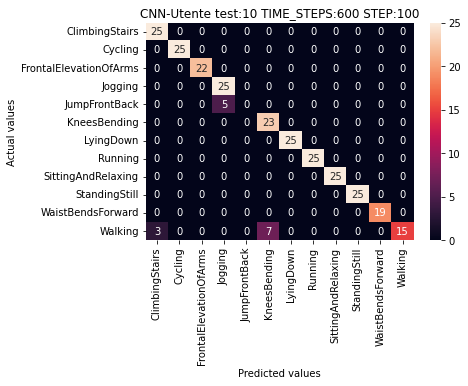

Accuracy media: 0.7053384365441694
F1 weighted media: 0.6633336403241048
F1 macro media: 0.627065882470749
   Time Steps  Step  Average accuracy  Average F1 Weighted  Average F1 Macro  \
0         600   100          0.705338             0.663334          0.627066   

                                             reports  \
0  [              precision    recall  f1-score  ...   

                                    confusion_matrix  
0  [AxesSubplot(0.125,0.125;0.62x0.755), AxesSubp...  


In [62]:
import itertools
import gc
from tabnanny import verbose
from tkinter import Y
batchsize=128

if leave_one_subject_out:
    cnn_results_dict = []
    cnn_results = pd.DataFrame()
    try:
        mkdir(cnn_dir + leave_one_subject_out_dir)
        mkdir(cnn_dir + leave_one_subject_out_dir + plot_dir)
    except OSError as error:
        print(error)

    for config in itertools.product(time_steps_list, step_list):

        time_step = config[0]
        step=config[1]

        cnn_f1_macro = []
        cnn_f1_weighted = []
        cnn_acc = []
        cnn_class_reports = []
        cnn_confusion_matrixes = []

        print(time_step,step)

        for user_id in users_ids:

            print("Utente test: ", user_id)

            X_test = np.array(data_cnn[time_step][step][user_id][0])
            y_test = np.array(data_cnn[time_step][step][user_id][1])

            X_train = []
            y_train = []

            for id in users_ids:
                if not id == user_id:
                    X_train += data_cnn[time_step][step][id][0]
                    y_train += data_cnn[time_step][step][id][1]
            
            X_train = np.array(X_train)
            y_train = np.array(y_train)

            scaler = RobustScaler()
            X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
            X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

            y_train = enc.transform(y_train)
            y_test = enc.transform(y_test)

            X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
            X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

      #      print(X_train)
       #     print(y_train)
        #    print(X_test)

         #   print(y_test)

            model = createCNN(X_train[0].shape, y_train[0].shape[0])

            callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

            XTraining, XValidation, YTraining, YValidation = train_test_split(X_train,y_train,stratify=y_train,test_size=0.2)

            print("Training: x->",len(XTraining),"y->",len(YTraining))
            print("Validation: x->",len(XValidation),"y->",len(YValidation))
            print("Testing: x->",len(X_test),"y->",len(y_test))
            print("Total: x->",len(XTraining)+len(XValidation)+len(X_test),"y->",len(YTraining)+len(YValidation)+len(y_test))

            model.fit(XTraining, YTraining, batch_size = batchsize, epochs = 100, validation_data=(XValidation,YValidation), verbose=1, callbacks=[callback], shuffle=True, workers=10, use_multiprocessing=True )

            rounded_labels=np.argmax(y_test, axis=1)
            y_pred = np.argmax(model.predict(X_test), axis=-1)

            cnn_acc.append(accuracy_score(rounded_labels, y_pred))
            cnn_f1_weighted.append(f1_score(rounded_labels, y_pred, average='weighted'))
            cnn_f1_macro.append(f1_score(rounded_labels, y_pred, average='macro'))
            #cnn_f1.append(f1_m(rounded_labels,y_pred))

            class_report = classification_report(rounded_labels, y_pred, digits=4)
            print(class_report)
            cnn_class_reports.append(class_report)
            
            conf_matrix = confusion_matrix(rounded_labels, y_pred, labels=range(0,len(enc.categories_[0])))

            ax = seaborn.heatmap(conf_matrix, annot=True, fmt='d')

            ax.set_title("CNN-Utente test:" + str(user_id) + " TIME_STEPS:"+str(time_step)+" STEP:"+str(step))

            ax.set_xlabel('Predicted values')
            ax.set_ylabel('Actual values')

            ax.xaxis.set_ticklabels(enc.categories_[0].tolist(), rotation=90)
            ax.yaxis.set_ticklabels(enc.categories_[0].tolist(), rotation=0)

            ax.get_figure().savefig(cnn_dir + leave_one_subject_out_dir + plot_dir +'/'+ax.get_title().replace(":"," ")+".png", dpi=500)
            #model_history_file=open(cnn_dir+'/'+ax.get_title().replace(":"," ")+".txt", "w")
            #model_history_file.write(model.history())
            #model_history_file.close()

            cnn_confusion_matrixes.append(ax)
            plt.show()

            gc.collect()            

        print("Accuracy media:",np.mean(cnn_acc))
        print("F1 weighted media:",np.mean(cnn_f1_weighted))
        print("F1 macro media:",np.mean(cnn_f1_macro))

        cnn_results_dict.append({
            'Time Steps':time_step,
            'Step':step,
            'Average accuracy':np.mean(cnn_acc),
            'Average F1 Weighted': np.mean(cnn_f1_weighted),
            'Average F1 Macro': np.mean(cnn_f1_macro),
            'reports':cnn_class_reports,
            'confusion_matrix':cnn_confusion_matrixes
        })
        
        cnn_results = pd.DataFrame(cnn_results_dict)
        print(cnn_results)
        cnn_results.to_csv(cnn_dir + leave_one_subject_out_dir + result_filename)


# Bi-LSTM

In [64]:
bilstm_dir = folder_name + "\\bilstm"
bilstm_plot_dir = bilstm_dir + "\\plot"
bilstm_result_filename = bilstm_dir + "\\result.csv"
bilstm_config_filename = bilstm_dir + "\\config_bilstm.txt"

mkdir(bilstm_dir)
mkdir(bilstm_plot_dir)

In [65]:
def createBiLSTM(input_size, output_size):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=64, return_sequences=True, input_shape=input_size)))
    model.add(Dropout(rate=0.2))
    model.add(Bidirectional(LSTM(units=64)))
    model.add(Dropout(rate=0.2))

    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(output_size, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


    
    return model

In [66]:
data_cnn = tuple_by_timestep

600 100
Utente test:  1
Epoch 1/100
16/16 [==============================] - 11s 196ms/step - loss: 2.2691 - accuracy: 0.2433 - val_loss: 1.8798 - val_accuracy: 0.3333
Epoch 2/100
16/16 [==============================] - 2s 110ms/step - loss: 1.7604 - accuracy: 0.3692 - val_loss: 1.3480 - val_accuracy: 0.5071
Epoch 3/100
16/16 [==============================] - 2s 109ms/step - loss: 1.4362 - accuracy: 0.4527 - val_loss: 1.1876 - val_accuracy: 0.5212
Epoch 4/100
16/16 [==============================] - 2s 111ms/step - loss: 1.3604 - accuracy: 0.4638 - val_loss: 1.1096 - val_accuracy: 0.5455
Epoch 5/100
16/16 [==============================] - 2s 110ms/step - loss: 1.2182 - accuracy: 0.5266 - val_loss: 0.9792 - val_accuracy: 0.5818
Epoch 6/100
16/16 [==============================] - 2s 109ms/step - loss: 1.1344 - accuracy: 0.5711 - val_loss: 0.9757 - val_accuracy: 0.5737
Epoch 7/100
16/16 [==============================] - 2s 112ms/step - loss: 1.0818 - accuracy: 0.5751 - val_loss: 0.91

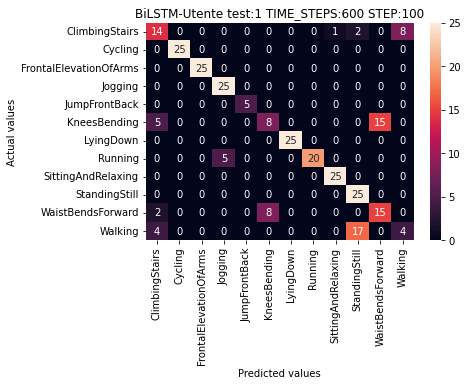

Utente test:  2
Epoch 1/100
16/16 [==============================] - 9s 198ms/step - loss: 2.2780 - accuracy: 0.2007 - val_loss: 1.9423 - val_accuracy: 0.3482
Epoch 2/100
16/16 [==============================] - 2s 109ms/step - loss: 1.8849 - accuracy: 0.3269 - val_loss: 1.5898 - val_accuracy: 0.4494
Epoch 3/100
16/16 [==============================] - 2s 110ms/step - loss: 1.5883 - accuracy: 0.4252 - val_loss: 1.2698 - val_accuracy: 0.4879
Epoch 4/100
16/16 [==============================] - 2s 111ms/step - loss: 1.3267 - accuracy: 0.5068 - val_loss: 1.0951 - val_accuracy: 0.5587
Epoch 5/100
16/16 [==============================] - 2s 110ms/step - loss: 1.2069 - accuracy: 0.5393 - val_loss: 0.9965 - val_accuracy: 0.6012
Epoch 6/100
16/16 [==============================] - 2s 112ms/step - loss: 1.0805 - accuracy: 0.5839 - val_loss: 0.9269 - val_accuracy: 0.6437
Epoch 7/100
16/16 [==============================] - 2s 115ms/step - loss: 1.0337 - accuracy: 0.5895 - val_loss: 0.9006 - val_

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.0714    0.0400    0.0513        25
           1     1.0000    1.0000    1.0000        25
           2     0.6087    1.0000    0.7568        28
           3     0.5263    0.4000    0.4545        25
           4     0.0000    0.0000    0.0000         5
           5     1.0000    0.5172    0.6818        29
           6     0.2857    0.4000    0.3333        25
           7     0.5833    0.8400    0.6885        25
           8     0.0000    0.0000    0.0000        25
           9     0.3425    1.0000    0.5102        25
          10     0.0000    0.0000    0.0000        26
          11     0.2917    0.2800    0.2857        25

    accuracy                         0.4931       288
   macro avg     0.3925    0.4564    0.3968       288
weighted avg     0.4291    0.4931    0.4307       288



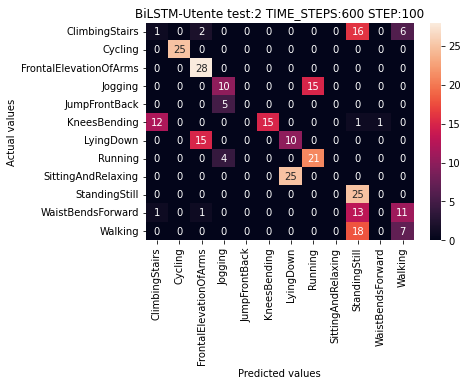

Utente test:  3
Epoch 1/100
16/16 [==============================] - 9s 196ms/step - loss: 2.2022 - accuracy: 0.2623 - val_loss: 1.7955 - val_accuracy: 0.3239
Epoch 2/100
16/16 [==============================] - 2s 108ms/step - loss: 1.7808 - accuracy: 0.3286 - val_loss: 1.4205 - val_accuracy: 0.4352
Epoch 3/100
16/16 [==============================] - 2s 109ms/step - loss: 1.4935 - accuracy: 0.4081 - val_loss: 1.1921 - val_accuracy: 0.5263
Epoch 4/100
16/16 [==============================] - 2s 108ms/step - loss: 1.3175 - accuracy: 0.4916 - val_loss: 1.0546 - val_accuracy: 0.5729
Epoch 5/100
16/16 [==============================] - 2s 108ms/step - loss: 1.2490 - accuracy: 0.4891 - val_loss: 1.0083 - val_accuracy: 0.5951
Epoch 6/100
16/16 [==============================] - 2s 108ms/step - loss: 1.1337 - accuracy: 0.5311 - val_loss: 0.9524 - val_accuracy: 0.5972
Epoch 7/100
16/16 [==============================] - 2s 111ms/step - loss: 1.0626 - accuracy: 0.5575 - val_loss: 0.9023 - val_

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


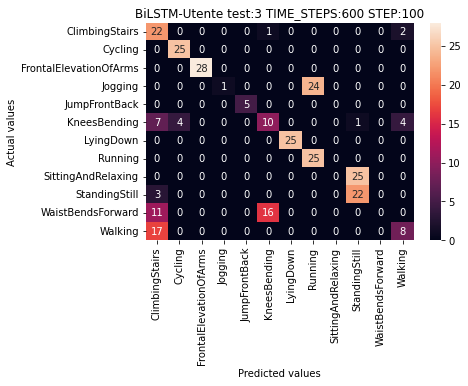

Utente test:  4
Epoch 1/100
16/16 [==============================] - 9s 196ms/step - loss: 2.2451 - accuracy: 0.2435 - val_loss: 1.8166 - val_accuracy: 0.4312
Epoch 2/100
16/16 [==============================] - 2s 111ms/step - loss: 1.7139 - accuracy: 0.3544 - val_loss: 1.3817 - val_accuracy: 0.5101
Epoch 3/100
16/16 [==============================] - 2s 111ms/step - loss: 1.4726 - accuracy: 0.4223 - val_loss: 1.1858 - val_accuracy: 0.5567
Epoch 4/100
16/16 [==============================] - 2s 110ms/step - loss: 1.2702 - accuracy: 0.5063 - val_loss: 1.1252 - val_accuracy: 0.6154
Epoch 5/100
16/16 [==============================] - 2s 111ms/step - loss: 1.2345 - accuracy: 0.5180 - val_loss: 1.0845 - val_accuracy: 0.5870
Epoch 6/100
16/16 [==============================] - 2s 111ms/step - loss: 1.0930 - accuracy: 0.5772 - val_loss: 0.9409 - val_accuracy: 0.6215
Epoch 7/100
16/16 [==============================] - 2s 113ms/step - loss: 0.9845 - accuracy: 0.6157 - val_loss: 0.9158 - val_

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.3333    0.0400    0.0714        25
           1     0.4630    1.0000    0.6329        25
           2     1.0000    0.9259    0.9615        27
           3     0.5000    1.0000    0.6667        25
           4     1.0000    1.0000    1.0000         5
           5     0.1429    0.5000    0.2222        26
           6     0.0000    0.0000    0.0000        25
           7     0.0000    0.0000    0.0000        25
           8     0.0000    0.0000    0.0000        25
           9     0.0000    0.0000    0.0000        25
          10     0.8000    0.1429    0.2424        28
          11     0.4643    0.5200    0.4906        25

    accuracy                         0.3881       286
   macro avg     0.3920    0.4274    0.3573       286
weighted avg     0.3571    0.3881    0.3149       286



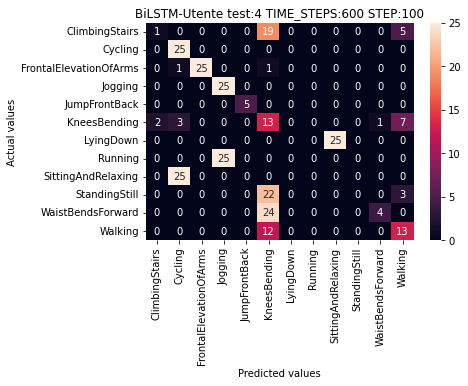

Utente test:  5
Epoch 1/100
16/16 [==============================] - 9s 196ms/step - loss: 2.2595 - accuracy: 0.2497 - val_loss: 1.8665 - val_accuracy: 0.3078
Epoch 2/100
16/16 [==============================] - 2s 113ms/step - loss: 1.8051 - accuracy: 0.3384 - val_loss: 1.4469 - val_accuracy: 0.4245
Epoch 3/100
16/16 [==============================] - 2s 113ms/step - loss: 1.5370 - accuracy: 0.4250 - val_loss: 1.1920 - val_accuracy: 0.4889
Epoch 4/100
16/16 [==============================] - 2s 110ms/step - loss: 1.3514 - accuracy: 0.4698 - val_loss: 1.1357 - val_accuracy: 0.5473
Epoch 5/100
16/16 [==============================] - 2s 111ms/step - loss: 1.2841 - accuracy: 0.4809 - val_loss: 1.0462 - val_accuracy: 0.5815
Epoch 6/100
16/16 [==============================] - 2s 111ms/step - loss: 1.1719 - accuracy: 0.5337 - val_loss: 0.9284 - val_accuracy: 0.6217
Epoch 7/100
16/16 [==============================] - 2s 112ms/step - loss: 1.1196 - accuracy: 0.5509 - val_loss: 0.9930 - val_

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


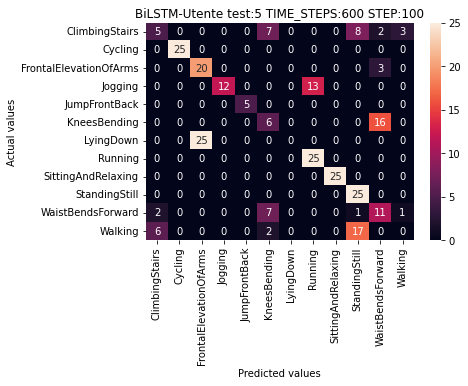

Utente test:  6
Epoch 1/100
16/16 [==============================] - 9s 197ms/step - loss: 2.2398 - accuracy: 0.1915 - val_loss: 1.9126 - val_accuracy: 0.2880
Epoch 2/100
16/16 [==============================] - 2s 111ms/step - loss: 1.8414 - accuracy: 0.3315 - val_loss: 1.4882 - val_accuracy: 0.4320
Epoch 3/100
16/16 [==============================] - 2s 112ms/step - loss: 1.5315 - accuracy: 0.4235 - val_loss: 1.2096 - val_accuracy: 0.5140
Epoch 4/100
16/16 [==============================] - 2s 112ms/step - loss: 1.4419 - accuracy: 0.4335 - val_loss: 1.1590 - val_accuracy: 0.5220
Epoch 5/100
16/16 [==============================] - 2s 112ms/step - loss: 1.3359 - accuracy: 0.4845 - val_loss: 1.0899 - val_accuracy: 0.5400
Epoch 6/100
16/16 [==============================] - 2s 110ms/step - loss: 1.2226 - accuracy: 0.5070 - val_loss: 1.0008 - val_accuracy: 0.5740
Epoch 7/100
16/16 [==============================] - 2s 114ms/step - loss: 1.1329 - accuracy: 0.5520 - val_loss: 0.9217 - val_

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.9444    0.6800    0.7907        25
           1     1.0000    1.0000    1.0000        25
           2     1.0000    0.9333    0.9655        15
           3     0.0000    0.0000    0.0000        25
           4     1.0000    1.0000    1.0000         5
           5     0.8889    0.8889    0.8889        18
           6     0.9615    1.0000    0.9804        25
           7     0.5319    1.0000    0.6944        25
           8     1.0000    1.0000    1.0000        25
           9     0.3333    0.7200    0.4557        25
          10     0.0000    0.0000    0.0000        17
          11     0.3684    0.2800    0.3182        25

    accuracy                         0.6941       255
   macro avg     0.6690    0.7085    0.6745       255
weighted avg     0.6451    0.6941    0.6528       255



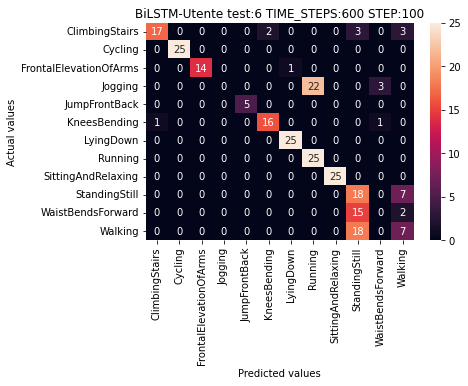

Utente test:  7
Epoch 1/100
16/16 [==============================] - 9s 199ms/step - loss: 2.2482 - accuracy: 0.2177 - val_loss: 1.9438 - val_accuracy: 0.3448
Epoch 2/100
16/16 [==============================] - 2s 111ms/step - loss: 1.8361 - accuracy: 0.3407 - val_loss: 1.5197 - val_accuracy: 0.4395
Epoch 3/100
16/16 [==============================] - 2s 113ms/step - loss: 1.5348 - accuracy: 0.4194 - val_loss: 1.2579 - val_accuracy: 0.5746
Epoch 4/100
16/16 [==============================] - 2s 114ms/step - loss: 1.3079 - accuracy: 0.5045 - val_loss: 1.1282 - val_accuracy: 0.5444
Epoch 5/100
16/16 [==============================] - 2s 113ms/step - loss: 1.2071 - accuracy: 0.5333 - val_loss: 1.0342 - val_accuracy: 0.5907
Epoch 6/100
16/16 [==============================] - 2s 111ms/step - loss: 1.1260 - accuracy: 0.5459 - val_loss: 1.0471 - val_accuracy: 0.6169
Epoch 7/100
16/16 [==============================] - 2s 112ms/step - loss: 1.0959 - accuracy: 0.5731 - val_loss: 1.0338 - val_

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        25
           1     1.0000    1.0000    1.0000        25
           2     0.4583    1.0000    0.6286        22
           3     0.9259    1.0000    0.9615        25
           4     1.0000    0.8000    0.8889         5
           5     0.3684    0.6087    0.4590        23
           6     0.0000    0.0000    0.0000        25
           7     1.0000    0.9200    0.9583        25
           8     0.7812    1.0000    0.8772        25
           9     0.3846    1.0000    0.5556        25
          10     0.5000    0.0400    0.0741        25
          11     0.2727    0.1200    0.1667        25

    accuracy                         0.6073       275
   macro avg     0.5576    0.6241    0.5475       275
weighted avg     0.5279    0.6073    0.5224       275



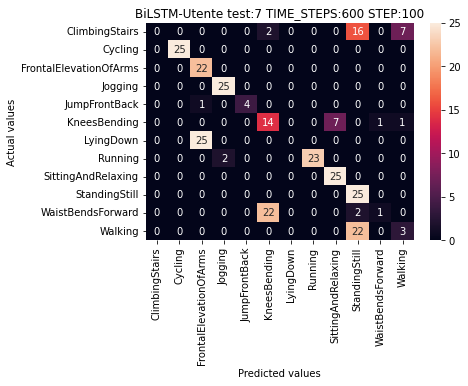

Utente test:  8
Epoch 1/100
16/16 [==============================] - 9s 194ms/step - loss: 2.2918 - accuracy: 0.2421 - val_loss: 1.9167 - val_accuracy: 0.3996
Epoch 2/100
16/16 [==============================] - 2s 112ms/step - loss: 1.8294 - accuracy: 0.3531 - val_loss: 1.4712 - val_accuracy: 0.4598
Epoch 3/100
16/16 [==============================] - 2s 111ms/step - loss: 1.5695 - accuracy: 0.4083 - val_loss: 1.2552 - val_accuracy: 0.4960
Epoch 4/100
16/16 [==============================] - 2s 110ms/step - loss: 1.4013 - accuracy: 0.4520 - val_loss: 1.0905 - val_accuracy: 0.5281
Epoch 5/100
16/16 [==============================] - 2s 113ms/step - loss: 1.2287 - accuracy: 0.5113 - val_loss: 1.0159 - val_accuracy: 0.6084
Epoch 6/100
16/16 [==============================] - 2s 115ms/step - loss: 1.1482 - accuracy: 0.5374 - val_loss: 0.9527 - val_accuracy: 0.6044
Epoch 7/100
16/16 [==============================] - 2s 112ms/step - loss: 1.0963 - accuracy: 0.5620 - val_loss: 0.9157 - val_

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        25
           1     1.0000    0.8400    0.9130        25
           2     1.0000    1.0000    1.0000        25
           3     0.7667    0.9200    0.8364        25
           4     1.0000    1.0000    1.0000         5
           5     0.2857    0.6000    0.3871        20
           6     1.0000    0.9600    0.9796        25
           7     0.9000    0.7200    0.8000        25
           8     0.9615    1.0000    0.9804        25
           9     0.0000    0.0000    0.0000        25
          10     0.0385    0.0625    0.0476        16
          11     0.6667    0.0800    0.1429        25

    accuracy                         0.5865       266
   macro avg     0.6349    0.5985    0.5906       266
weighted avg     0.6342    0.5865    0.5820       266



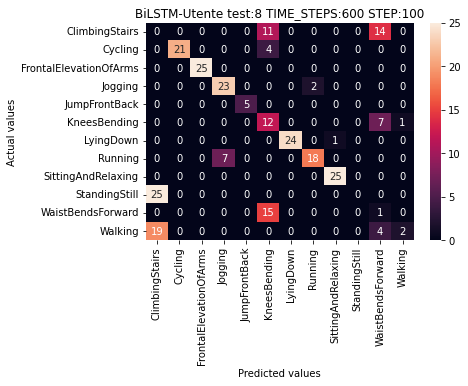

Utente test:  9
Epoch 1/100
16/16 [==============================] - 9s 196ms/step - loss: 2.2689 - accuracy: 0.2445 - val_loss: 1.9191 - val_accuracy: 0.3185
Epoch 2/100
16/16 [==============================] - 2s 112ms/step - loss: 1.8100 - accuracy: 0.3357 - val_loss: 1.4828 - val_accuracy: 0.4315
Epoch 3/100
16/16 [==============================] - 2s 112ms/step - loss: 1.5236 - accuracy: 0.4259 - val_loss: 1.2564 - val_accuracy: 0.4980
Epoch 4/100
16/16 [==============================] - 2s 111ms/step - loss: 1.3458 - accuracy: 0.4632 - val_loss: 1.1548 - val_accuracy: 0.5081
Epoch 5/100
16/16 [==============================] - 2s 113ms/step - loss: 1.2782 - accuracy: 0.4793 - val_loss: 1.0804 - val_accuracy: 0.5665
Epoch 6/100
16/16 [==============================] - 2s 112ms/step - loss: 1.1610 - accuracy: 0.5348 - val_loss: 0.9585 - val_accuracy: 0.6270
Epoch 7/100
16/16 [==============================] - 2s 110ms/step - loss: 1.1485 - accuracy: 0.5192 - val_loss: 1.0230 - val_

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.6053    0.9200    0.7302        25
           1     1.0000    1.0000    1.0000        25
           2     1.0000    1.0000    1.0000        23
           3     0.9615    1.0000    0.9804        25
           4     1.0000    1.0000    1.0000         5
           5     0.6957    0.6667    0.6809        24
           6     1.0000    1.0000    1.0000        25
           7     1.0000    0.9600    0.9796        25
           8     1.0000    1.0000    1.0000        25
           9     0.5556    1.0000    0.7143        25
          10     0.5000    0.3478    0.4103        23
          11     0.0000    0.0000    0.0000        25

    accuracy                         0.8145       275
   macro avg     0.7765    0.8245    0.7913       275
weighted avg     0.7609    0.8145    0.7778       275



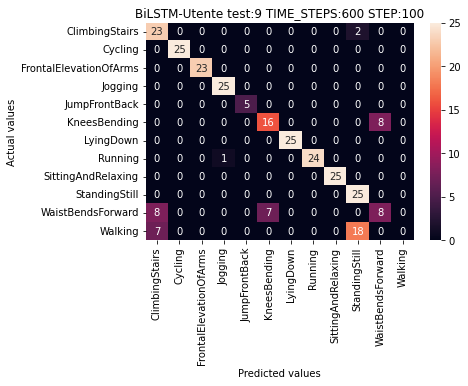

Utente test:  10
Epoch 1/100
16/16 [==============================] - 9s 197ms/step - loss: 2.2075 - accuracy: 0.2681 - val_loss: 1.7520 - val_accuracy: 0.3574
Epoch 2/100
16/16 [==============================] - 2s 114ms/step - loss: 1.6731 - accuracy: 0.3722 - val_loss: 1.3302 - val_accuracy: 0.4598
Epoch 3/100
16/16 [==============================] - 2s 114ms/step - loss: 1.4729 - accuracy: 0.4125 - val_loss: 1.1646 - val_accuracy: 0.5402
Epoch 4/100
16/16 [==============================] - 2s 113ms/step - loss: 1.3194 - accuracy: 0.4668 - val_loss: 1.0461 - val_accuracy: 0.5884
Epoch 5/100
16/16 [==============================] - 2s 115ms/step - loss: 1.1995 - accuracy: 0.5211 - val_loss: 0.9680 - val_accuracy: 0.5863
Epoch 6/100
16/16 [==============================] - 2s 113ms/step - loss: 1.1497 - accuracy: 0.5402 - val_loss: 0.9763 - val_accuracy: 0.5843
Epoch 7/100
16/16 [==============================] - 2s 114ms/step - loss: 1.0754 - accuracy: 0.5679 - val_loss: 0.8960 - val

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.4340    0.9200    0.5897        25
           1     1.0000    0.8000    0.8889        25
           2     1.0000    0.9545    0.9767        22
           3     0.5435    1.0000    0.7042        25
           4     0.0000    0.0000    0.0000         5
           5     0.0000    0.0000    0.0000        23
           6     0.9000    0.3600    0.5143        25
           7     1.0000    1.0000    1.0000        25
           8     0.8333    1.0000    0.9091        25
           9     0.2500    0.1600    0.1951        25
          10     0.4500    0.9474    0.6102        19
          11     1.0000    0.3200    0.4848        25

    accuracy                         0.6617       269
   macro avg     0.6176    0.6218    0.5728       269
weighted avg     0.6675    0.6617    0.6143       269



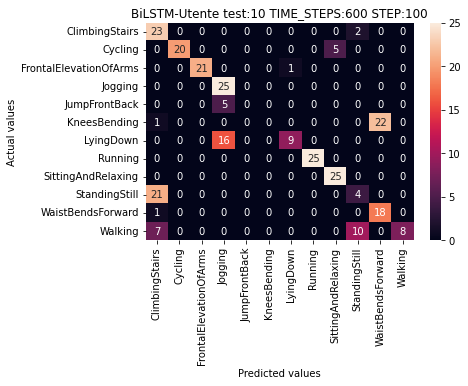

Accuracy media: 0.6190991279956439
F1 media macro: 0.579798135561014
F1 media weighted: 0.579798135561014


In [67]:
import itertools
import gc
bilstm_results_dict = []
bilstm_results = pd.DataFrame()

if bilstm_one_subject_out:

    for config in itertools.product(time_steps_list, step_list):

        time_step = config[0]
        step=config[1]

        bilstm_f1_weighted = []
        bilstm_f1_macro = []
        bilstm_acc = []
        bilstm_class_reports = []
        bilstm_confusion_matrixes = []

        print(time_step,step)

        for user_id in users_ids:

            print("Utente test: ", user_id)

            X_test = np.array(data_cnn[time_step][step][user_id][0])
            y_test = np.array(data_cnn[time_step][step][user_id][1])

            X_train = []
            y_train = []

            for id in users_ids:
                if id != user_id:
                    X_train += data_cnn[time_step][step][id][0]
                    y_train += data_cnn[time_step][step][id][1]
            
            X_train = np.array(X_train)
            y_train = np.array(y_train)

            y_train = enc.transform(y_train)
            y_test = enc.transform(y_test)

            scaler = RobustScaler()
            X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
            X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
            
            #X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
            #X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

            model = createBiLSTM([X_train[0].shape[0], X_train[0].shape[1]], y_train[0].shape[0])

            callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=True, restore_best_weights=True)

            XTraining, XValidation, YTraining, YValidation = train_test_split(X_train,y_train,stratify=y_train,test_size=0.2)

            model.fit(XTraining, YTraining, batch_size = batchsize, epochs = 100, validation_data=(XValidation,YValidation), verbose=1, callbacks=[callback], shuffle=True )
            
            rounded_labels=np.argmax(y_test, axis=1)
            y_pred = np.argmax(model.predict(X_test), axis=-1)

            bilstm_acc.append(accuracy_score(rounded_labels, y_pred))
            bilstm_f1_weighted.append(f1_score(rounded_labels, y_pred, average='weighted'))
            bilstm_f1_macro.append(f1_score(rounded_labels, y_pred, average='macro'))
            #bilstm_f1.append(f1_m(rounded_labels,y_pred))

            class_report = classification_report(rounded_labels, y_pred, digits=4)
            print(class_report)
            bilstm_class_reports.append(class_report)
            
            conf_matrix = confusion_matrix(rounded_labels, y_pred, labels=range(0,len(enc.categories_[0])))

            ax = seaborn.heatmap(conf_matrix, annot=True, fmt='d')

            ax.set_title("BiLSTM-Utente test:" + str(user_id) + " TIME_STEPS:"+str(time_step)+" STEP:"+str(step))

            ax.set_xlabel('Predicted values')
            ax.set_ylabel('Actual values')

            ax.xaxis.set_ticklabels(enc.categories_[0].tolist(), rotation=90)
            ax.yaxis.set_ticklabels(enc.categories_[0].tolist(), rotation=0)

            ax.get_figure().savefig(bilstm_plot_dir+'/'+ax.get_title().replace(":"," ")+".png", dpi=500)

            bilstm_confusion_matrixes.append(ax)
            plt.show()

            gc.collect()





            

        print("Accuracy media:",np.mean(bilstm_acc))
        print("F1 media macro:",np.mean(bilstm_f1_macro))
        print("F1 media weighted:",np.mean(bilstm_f1_macro))

        bilstm_results_dict.append({
            'Time Steps':time_step,
            'Step':step,
            'Average accuracy':np.mean(bilstm_acc),
            'Average F1 weighted': np.mean(bilstm_f1_weighted),
            'Average F1 macro': np.mean(bilstm_f1_macro),
            'reports':bilstm_class_reports,
            'confusion_matrix':bilstm_confusion_matrixes
        })

    bilstm_config_file = open(bilstm_config_filename, "a")
    model.summary(print_fn=lambda x: bilstm_config_file.write(x))
    bilstm_config_file.close()

In [68]:
bilstm_results_dataframe = pd.DataFrame(bilstm_results_dict)
bilstm_results_dataframe.to_csv(bilstm_result_filename)
bilstm_results_dataframe

,Time Steps,Step,Average accuracy,Average F1 weighted,Average F1 macro,reports,confusion_matrix
0,600,100,0.619099,0.568159,0.579798,[ precision recall f1-score ...,"[AxesSubplot(0.125,0.125;0.62x0.755), AxesSubp..."


# SHALLOW LEARNING

## Random Forest

In [88]:
rf_dir = folder_name + "\\rf"
plot_dir = "\\plot"
result_filename = "\\result.csv"
config_filename = "\\config.txt"

try:
    mkdir(rf_dir )
    mkdir(rf_dir + plot_dir)
except OSError as error:
    print(error)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   41.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.3s finished
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Us

                        precision    recall  f1-score   support

        ClimbingStairs       0.51      1.00      0.68        25
               Cycling       1.00      1.00      1.00        25
FrontalElevationOfArms       1.00      1.00      1.00        25
               Jogging       0.76      1.00      0.86        25
         JumpFrontBack       0.00      0.00      0.00         5
          KneesBending       1.00      0.14      0.25        28
             LyingDown       1.00      1.00      1.00        25
               Running       1.00      0.88      0.94        25
    SittingAndRelaxing       0.00      0.00      0.00        25
         StandingStill       1.00      1.00      1.00        25
     WaistBendsForward       0.50      1.00      0.67        25
               Walking       1.00      1.00      1.00        25

              accuracy                           0.80       283
             macro avg       0.73      0.75      0.70       283
          weighted avg       0.79     

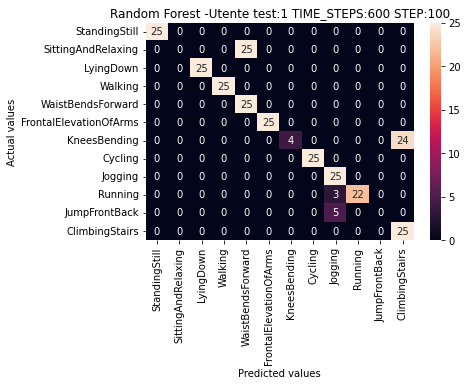

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   42.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.4s finished
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Us

                        precision    recall  f1-score   support

        ClimbingStairs       0.46      1.00      0.63        25
               Cycling       1.00      1.00      1.00        25
FrontalElevationOfArms       0.97      1.00      0.98        28
               Jogging       0.50      0.36      0.42        25
         JumpFrontBack       0.00      0.00      0.00         5
          KneesBending       1.00      0.83      0.91        29
             LyingDown       1.00      1.00      1.00        25
               Running       0.56      0.80      0.66        25
    SittingAndRelaxing       1.00      1.00      1.00        25
         StandingStill       1.00      1.00      1.00        25
     WaistBendsForward       0.00      0.00      0.00        26
               Walking       1.00      1.00      1.00        25

              accuracy                           0.80       288
             macro avg       0.71      0.75      0.72       288
          weighted avg       0.76     

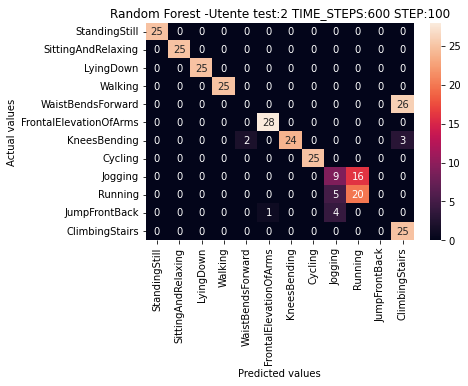

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   41.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.3s finished
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Us

                        precision    recall  f1-score   support

        ClimbingStairs       1.00      1.00      1.00        25
               Cycling       0.96      1.00      0.98        25
FrontalElevationOfArms       1.00      1.00      1.00        28
               Jogging       0.83      1.00      0.91        25
         JumpFrontBack       0.00      0.00      0.00         5
          KneesBending       0.54      0.96      0.69        26
             LyingDown       1.00      1.00      1.00        25
               Running       1.00      1.00      1.00        25
    SittingAndRelaxing       0.00      0.00      0.00        25
         StandingStill       0.50      1.00      0.67        25
     WaistBendsForward       1.00      0.22      0.36        27
               Walking       1.00      1.00      1.00        25

              accuracy                           0.82       286
             macro avg       0.74      0.77      0.72       286
          weighted avg       0.79     

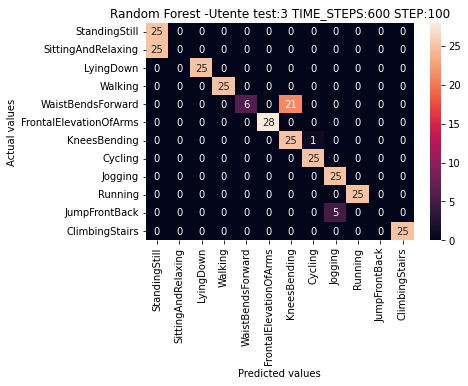

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   43.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.3s finished
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Us

                        precision    recall  f1-score   support

        ClimbingStairs       0.86      0.24      0.38        25
               Cycling       0.33      1.00      0.50        25
FrontalElevationOfArms       1.00      1.00      1.00        27
               Jogging       0.46      1.00      0.63        25
         JumpFrontBack       0.00      0.00      0.00         5
          KneesBending       0.20      0.69      0.31        26
             LyingDown       0.00      0.00      0.00        25
               Running       0.00      0.00      0.00        25
    SittingAndRelaxing       0.00      0.00      0.00        25
         StandingStill       0.00      0.00      0.00        25
     WaistBendsForward       1.00      0.50      0.67        28
               Walking       0.56      0.36      0.44        25

              accuracy                           0.43       286
             macro avg       0.37      0.40      0.33       286
          weighted avg       0.40     

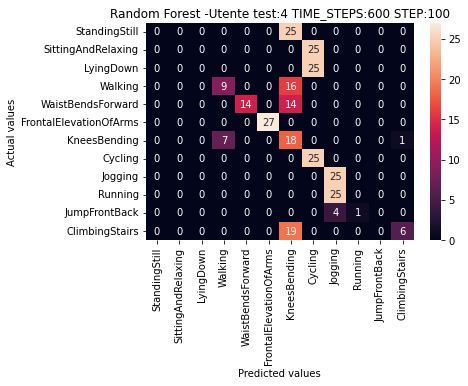

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   42.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.3s finished
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Us

                        precision    recall  f1-score   support

        ClimbingStairs       0.86      1.00      0.93        25
               Cycling       1.00      1.00      1.00        25
FrontalElevationOfArms       1.00      1.00      1.00        23
               Jogging       0.42      1.00      0.60        25
         JumpFrontBack       1.00      0.20      0.33         5
          KneesBending       0.56      1.00      0.72        22
             LyingDown       1.00      1.00      1.00        25
               Running       1.00      0.80      0.89        25
    SittingAndRelaxing       0.00      0.00      0.00        25
         StandingStill       1.00      1.00      1.00        25
     WaistBendsForward       0.96      1.00      0.98        22
               Walking       1.00      0.12      0.21        25

              accuracy                           0.79       272
             macro avg       0.82      0.76      0.72       272
          weighted avg       0.80     

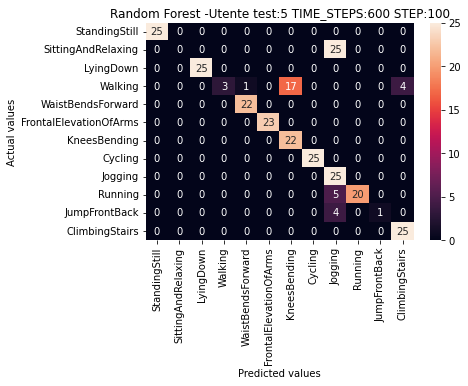

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   42.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.3s finished
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Us

                        precision    recall  f1-score   support

        ClimbingStairs       1.00      1.00      1.00        25
               Cycling       1.00      1.00      1.00        25
FrontalElevationOfArms       1.00      1.00      1.00        15
               Jogging       0.00      0.00      0.00        25
         JumpFrontBack       0.00      0.00      0.00         5
          KneesBending       1.00      1.00      1.00        18
             LyingDown       1.00      1.00      1.00        25
               Running       0.50      1.00      0.67        25
    SittingAndRelaxing       1.00      1.00      1.00        25
         StandingStill       1.00      1.00      1.00        25
     WaistBendsForward       0.00      0.00      0.00        17
               Walking       0.60      1.00      0.75        25

              accuracy                           0.82       255
             macro avg       0.67      0.75      0.70       255
          weighted avg       0.73     

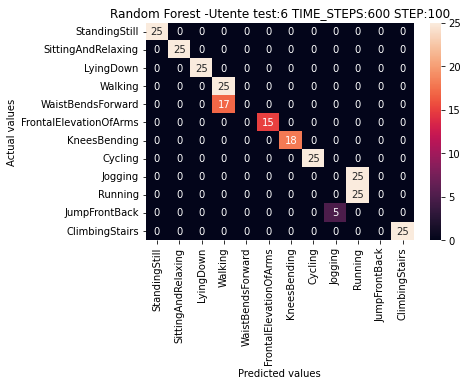

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   42.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.3s finished
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Us

                        precision    recall  f1-score   support

        ClimbingStairs       0.00      0.00      0.00        25
               Cycling       1.00      1.00      1.00        25
FrontalElevationOfArms       0.96      1.00      0.98        22
               Jogging       0.49      1.00      0.66        25
         JumpFrontBack       1.00      0.20      0.33         5
          KneesBending       0.00      0.00      0.00        23
             LyingDown       0.50      1.00      0.67        25
               Running       1.00      0.08      0.15        25
    SittingAndRelaxing       0.00      0.00      0.00        25
         StandingStill       1.00      1.00      1.00        25
     WaistBendsForward       0.00      0.00      0.00        25
               Walking       0.00      0.00      0.00        25

              accuracy                           0.45       275
             macro avg       0.50      0.44      0.40       275
          weighted avg       0.46     

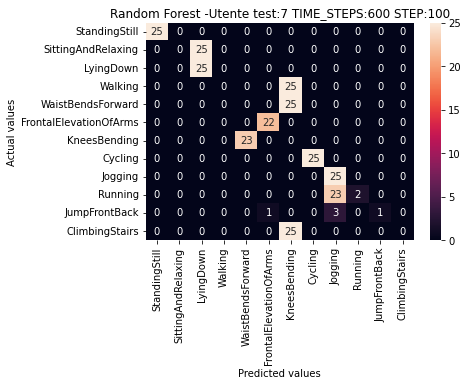

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   42.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.3s finished
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Us

                        precision    recall  f1-score   support

        ClimbingStairs       0.78      1.00      0.88        25
               Cycling       1.00      1.00      1.00        25
FrontalElevationOfArms       1.00      1.00      1.00        25
               Jogging       0.83      0.96      0.89        25
         JumpFrontBack       0.00      0.00      0.00         5
          KneesBending       0.94      0.85      0.89        20
             LyingDown       1.00      1.00      1.00        25
               Running       0.96      1.00      0.98        25
    SittingAndRelaxing       1.00      1.00      1.00        25
         StandingStill       1.00      1.00      1.00        25
     WaistBendsForward       1.00      0.94      0.97        16
               Walking       1.00      0.84      0.91        25

              accuracy                           0.95       266
             macro avg       0.88      0.88      0.88       266
          weighted avg       0.94     

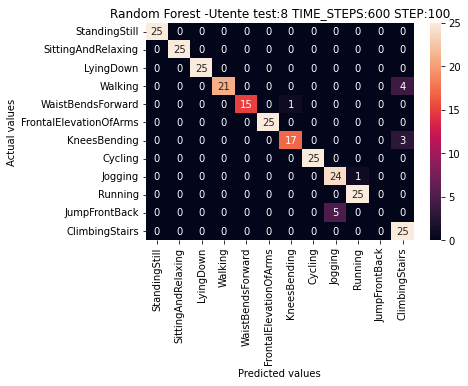

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   41.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.3s finished


                        precision    recall  f1-score   support

        ClimbingStairs       1.00      1.00      1.00        25
               Cycling       1.00      1.00      1.00        25
FrontalElevationOfArms       1.00      1.00      1.00        23
               Jogging       0.88      0.56      0.68        25
         JumpFrontBack       1.00      0.60      0.75         5
          KneesBending       1.00      0.83      0.91        24
             LyingDown       1.00      1.00      1.00        25
               Running       0.69      1.00      0.82        25
    SittingAndRelaxing       1.00      1.00      1.00        25
         StandingStill       1.00      1.00      1.00        25
     WaistBendsForward       0.85      1.00      0.92        23
               Walking       1.00      1.00      1.00        25

              accuracy                           0.94       275
             macro avg       0.95      0.92      0.92       275
          weighted avg       0.95     

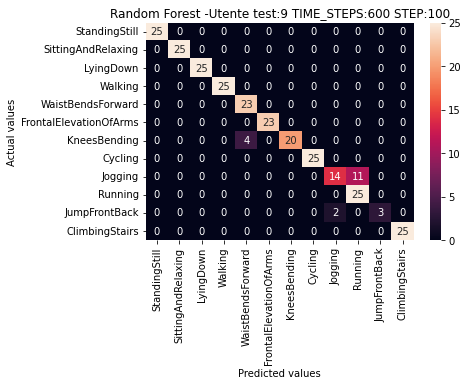

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   41.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.3s finished
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Us

                        precision    recall  f1-score   support

        ClimbingStairs       0.81      1.00      0.89        25
               Cycling       1.00      1.00      1.00        25
FrontalElevationOfArms       1.00      1.00      1.00        22
               Jogging       0.83      1.00      0.91        25
         JumpFrontBack       0.00      0.00      0.00         5
          KneesBending       1.00      1.00      1.00        23
             LyingDown       1.00      1.00      1.00        25
               Running       1.00      1.00      1.00        25
    SittingAndRelaxing       1.00      1.00      1.00        25
         StandingStill       1.00      1.00      1.00        25
     WaistBendsForward       1.00      1.00      1.00        19
               Walking       1.00      0.76      0.86        25

              accuracy                           0.96       269
             macro avg       0.89      0.90      0.89       269
          weighted avg       0.95     

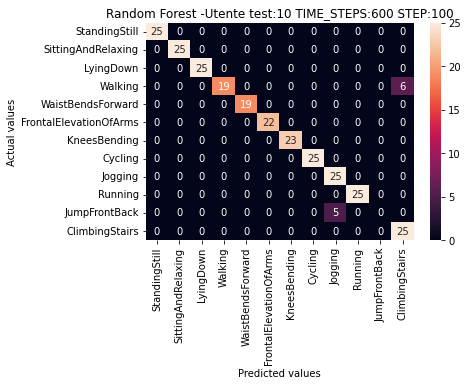

F1 total:  0.7367316736947347
Accuracy total:  0.7761425579559729
   Time Steps  Step  Average accuracy  Average F1
0         600   100          0.776143    0.736732


In [89]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

rf_results = []

gc.collect()
for config in itertools.product(time_steps_list, step_list):



    time_step = config[0]
    step=config[1]

    tuple = tuple_by_timestep[time_steps][step]

    f1_list = []
    acc_list = []

    for user_id in users_ids:

        x_test = tuple[user_id][0]
        y_test = tuple[user_id][1]

        x_train = []
        y_train = []

        for id in users_ids:
            if id != user_id:
                x_train+=tuple[id][0]
                y_train+=tuple[id][1]
        
        x_train = [x_train[i].flatten() for i in range(len(x_train)) ]
        x_test = [x_test[i].flatten() for i in range(len(x_test))]

        y_train = np.array(y_train).flatten()
        y_test = np.array(y_test).flatten()

        scaler = MinMaxScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)

        model = RandomForestClassifier(n_jobs=-1,n_estimators=1000,random_state=seed, verbose=True)

        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)

        conf_mat = confusion_matrix(y_test, y_pred, labels=classes)

        f1 = f1_score(y_test, y_pred, average='weighted')
        acc = accuracy_score(y_test, y_pred)

        print(classification_report(y_test, y_pred))

        ax = seaborn.heatmap(conf_mat, annot=True, fmt='d')

        ax.set_title("Random Forest -Utente test:" + str(user_id) + " TIME_STEPS:"+str(time_step)+" STEP:"+str(step))
        ax.get_figure().savefig(rf_dir+plot_dir+'/'+ax.get_title().replace(":"," ")+".png", dpi=500)
        ax.set_xlabel('Predicted values')
        ax.set_ylabel('Actual values')

        ax.xaxis.set_ticklabels(classes, rotation=90)
        ax.yaxis.set_ticklabels(classes, rotation=0)


        print("f1: ", f1)
        print("acc: ", acc)

        f1_list.append(f1)
        acc_list.append(acc)


        plt.show()
    
    print("F1 total: ", np.mean(f1_list))
    print("Accuracy total: ", np.mean(acc_list))

    rf_results.append({
    'Time Steps':time_step,
    'Step':step,
    'Average accuracy':np.mean(acc_list),
    'Average F1': np.mean(f1_list),
    })

rf_results_df = pd.DataFrame(rf_results)
rf_results_df.to_csv(rf_dir + result_filename)
print(rf_results_df)


## SVM

In [ ]:
svm_dir = folder_name + "\\svm"
plot_dir = "\\plot"
result_filename = "\\result.csv"
config_filename = "\\config.txt"

try:
    mkdir(svm_dir )
    mkdir(svm_dir + plot_dir)
except OSError as error:
    print(error)

[LibSVM]

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                        precision    recall  f1-score   support

        ClimbingStairs       0.33      0.32      0.33        25
               Cycling       1.00      1.00      1.00        25
FrontalElevationOfArms       1.00      1.00      1.00        25
               Jogging       0.74      1.00      0.85        25
         JumpFrontBack       1.00      0.40      0.57         5
          KneesBending       0.25      0.18      0.21        28
             LyingDown       1.00      1.00      1.00        25
               Running       1.00      0.76      0.86        25
    SittingAndRelaxing       0.00      0.00      0.00        25
         StandingStill       0.49      1.00      0.66        25
     WaistBendsForward       0.28      0.28      0.28        25
               Walking       0.73      0.96      0.83        25

              accuracy                           0.67       283
             macro avg       0.65      0.66      0.63       283
          weighted avg       0.62     

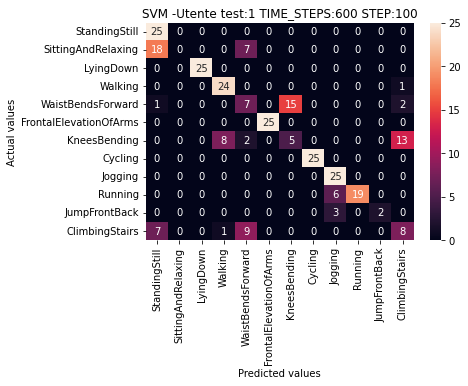

[LibSVM]

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                        precision    recall  f1-score   support

        ClimbingStairs       0.68      1.00      0.81        25
               Cycling       1.00      1.00      1.00        25
FrontalElevationOfArms       1.00      1.00      1.00        28
               Jogging       0.53      0.32      0.40        25
         JumpFrontBack       0.00      0.00      0.00         5
          KneesBending       1.00      0.41      0.59        29
             LyingDown       1.00      1.00      1.00        25
               Running       0.57      0.92      0.71        25
    SittingAndRelaxing       0.96      1.00      0.98        25
         StandingStill       0.53      1.00      0.69        25
     WaistBendsForward       0.00      0.00      0.00        26
               Walking       0.83      0.96      0.89        25

              accuracy                           0.76       288
             macro avg       0.68      0.72      0.67       288
          weighted avg       0.73     

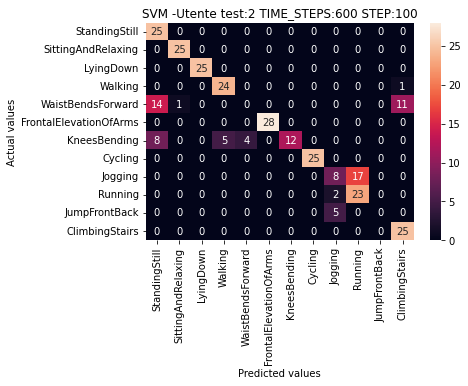

[LibSVM]

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                        precision    recall  f1-score   support

        ClimbingStairs       0.00      0.00      0.00        25
               Cycling       1.00      1.00      1.00        25
FrontalElevationOfArms       1.00      1.00      1.00        28
               Jogging       1.00      0.96      0.98        25
         JumpFrontBack       0.00      0.00      0.00         5
          KneesBending       0.40      0.88      0.55        26
             LyingDown       1.00      1.00      1.00        25
               Running       0.81      1.00      0.89        25
    SittingAndRelaxing       0.00      0.00      0.00        25
         StandingStill       0.53      1.00      0.69        25
     WaistBendsForward       0.28      0.19      0.22        27
               Walking       0.83      1.00      0.91        25

              accuracy                           0.72       286
             macro avg       0.57      0.67      0.60       286
          weighted avg       0.61     

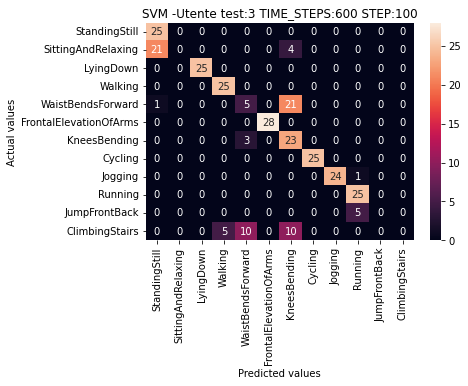

[LibSVM]

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                        precision    recall  f1-score   support

        ClimbingStairs       1.00      0.12      0.21        25
               Cycling       0.50      1.00      0.67        25
FrontalElevationOfArms       1.00      1.00      1.00        27
               Jogging       0.46      0.88      0.60        25
         JumpFrontBack       0.00      0.00      0.00         5
          KneesBending       0.08      0.27      0.13        26
             LyingDown       0.00      0.00      0.00        25
               Running       0.25      0.04      0.07        25
    SittingAndRelaxing       0.00      0.00      0.00        25
         StandingStill       0.00      0.00      0.00        25
     WaistBendsForward       0.91      0.36      0.51        28
               Walking       0.00      0.00      0.00        25

              accuracy                           0.33       286
             macro avg       0.35      0.31      0.27       286
          weighted avg       0.38     

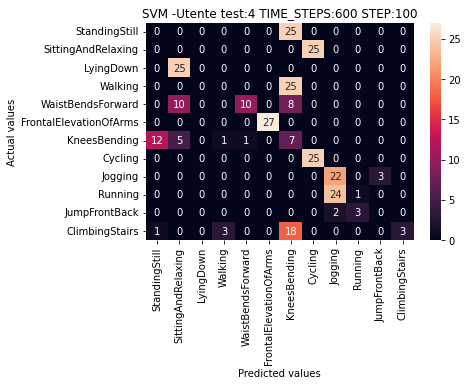

[LibSVM]

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                        precision    recall  f1-score   support

        ClimbingStairs       0.42      0.32      0.36        25
               Cycling       1.00      1.00      1.00        25
FrontalElevationOfArms       1.00      1.00      1.00        23
               Jogging       0.85      0.92      0.88        25
         JumpFrontBack       1.00      0.20      0.33         5
          KneesBending       0.75      0.82      0.78        22
             LyingDown       1.00      1.00      1.00        25
               Running       0.93      1.00      0.96        25
    SittingAndRelaxing       0.00      0.00      0.00        25
         StandingStill       1.00      1.00      1.00        25
     WaistBendsForward       0.24      0.45      0.32        22
               Walking       0.71      1.00      0.83        25

              accuracy                           0.76       272
             macro avg       0.74      0.73      0.71       272
          weighted avg       0.73     

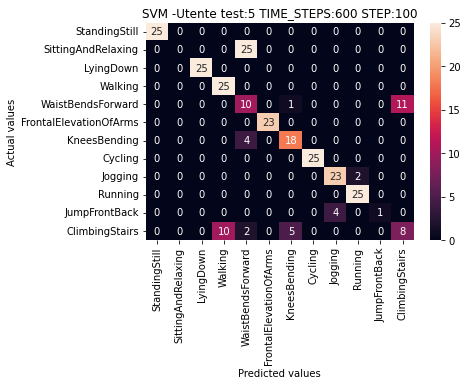

[LibSVM]

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                        precision    recall  f1-score   support

        ClimbingStairs       0.41      0.36      0.38        25
               Cycling       1.00      1.00      1.00        25
FrontalElevationOfArms       0.00      0.00      0.00        15
               Jogging       0.00      0.00      0.00        25
         JumpFrontBack       1.00      0.80      0.89         5
          KneesBending       0.57      0.22      0.32        18
             LyingDown       0.62      1.00      0.77        25
               Running       0.50      1.00      0.67        25
    SittingAndRelaxing       1.00      1.00      1.00        25
         StandingStill       1.00      1.00      1.00        25
     WaistBendsForward       0.50      0.12      0.19        17
               Walking       0.48      1.00      0.65        25

              accuracy                           0.66       255
             macro avg       0.59      0.62      0.57       255
          weighted avg       0.58     

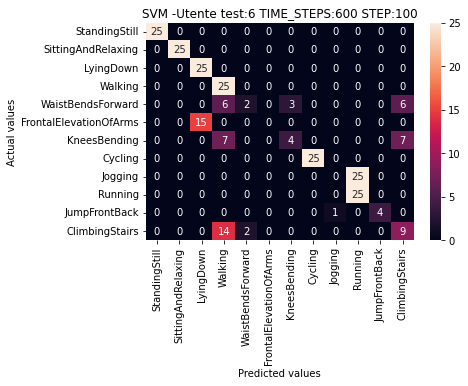

[LibSVM]

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                        precision    recall  f1-score   support

        ClimbingStairs       0.96      0.88      0.92        25
               Cycling       1.00      1.00      1.00        25
FrontalElevationOfArms       0.42      1.00      0.59        22
               Jogging       0.49      0.88      0.63        25
         JumpFrontBack       0.00      0.00      0.00         5
          KneesBending       0.03      0.04      0.04        23
             LyingDown       0.00      0.00      0.00        25
               Running       1.00      0.04      0.08        25
    SittingAndRelaxing       0.74      1.00      0.85        25
         StandingStill       0.38      0.48      0.42        25
     WaistBendsForward       0.00      0.00      0.00        25
               Walking       1.00      0.28      0.44        25

              accuracy                           0.50       275
             macro avg       0.50      0.47      0.41       275
          weighted avg       0.54     

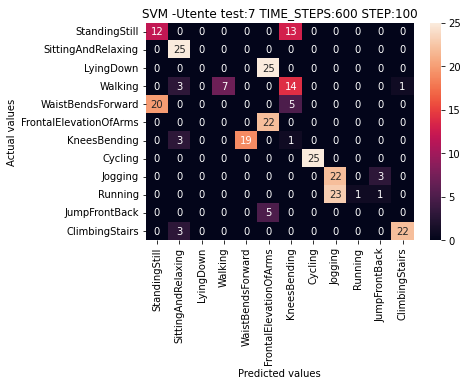

[LibSVM]

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                        precision    recall  f1-score   support

        ClimbingStairs       0.56      0.36      0.44        25
               Cycling       1.00      0.52      0.68        25
FrontalElevationOfArms       1.00      1.00      1.00        25
               Jogging       0.89      0.96      0.92        25
         JumpFrontBack       1.00      0.40      0.57         5
          KneesBending       0.33      0.45      0.38        20
             LyingDown       0.00      0.00      0.00        25
               Running       0.88      0.92      0.90        25
    SittingAndRelaxing       0.40      1.00      0.57        25
         StandingStill       1.00      1.00      1.00        25
     WaistBendsForward       0.41      0.75      0.53        16
               Walking       0.79      0.44      0.56        25

              accuracy                           0.67       266
             macro avg       0.69      0.65      0.63       266
          weighted avg       0.68     

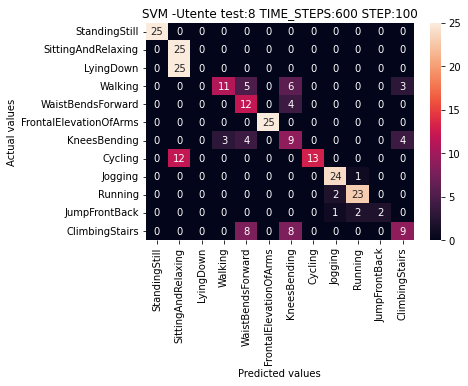

[LibSVM]                        precision    recall  f1-score   support

        ClimbingStairs       0.67      0.40      0.50        25
               Cycling       1.00      1.00      1.00        25
FrontalElevationOfArms       1.00      1.00      1.00        23
               Jogging       0.93      1.00      0.96        25
         JumpFrontBack       1.00      0.60      0.75         5
          KneesBending       0.39      0.50      0.44        24
             LyingDown       1.00      1.00      1.00        25
               Running       1.00      1.00      1.00        25
    SittingAndRelaxing       1.00      1.00      1.00        25
         StandingStill       1.00      1.00      1.00        25
     WaistBendsForward       0.58      0.78      0.67        23
               Walking       0.95      0.76      0.84        25

              accuracy                           0.85       275
             macro avg       0.88      0.84      0.85       275
          weighted avg       0

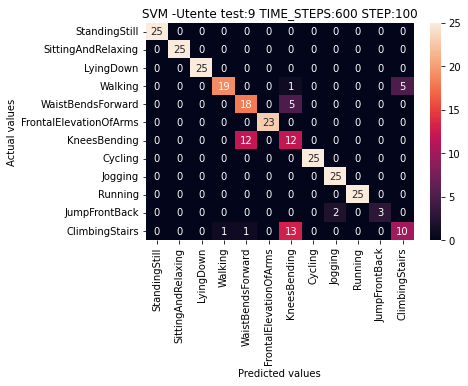

[LibSVM]

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                        precision    recall  f1-score   support

        ClimbingStairs       0.64      1.00      0.78        25
               Cycling       1.00      0.96      0.98        25
FrontalElevationOfArms       1.00      1.00      1.00        22
               Jogging       0.89      1.00      0.94        25
         JumpFrontBack       1.00      0.20      0.33         5
          KneesBending       0.88      0.30      0.45        23
             LyingDown       1.00      1.00      1.00        25
               Running       0.96      1.00      0.98        25
    SittingAndRelaxing       0.96      1.00      0.98        25
         StandingStill       0.61      1.00      0.76        25
     WaistBendsForward       0.66      1.00      0.79        19
               Walking       0.00      0.00      0.00        25

              accuracy                           0.83       269
             macro avg       0.80      0.79      0.75       269
          weighted avg       0.79     

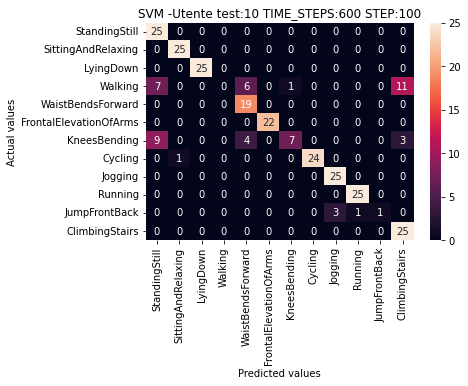

F1 weighted total:  0.6335863568652951
F1 macro total:  0.6093458134856243
Accuracy total:  0.6762565497690867
   Time Steps  Step  Average accuracy  Average F1 macro  Average F1 weighted
0         600   100          0.676257          0.609346             0.633586


In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

svm_results = []

gc.collect()
for config in itertools.product(time_steps_list, step_list):

    time_step = config[0]
    step=config[1]

    tuple = tuple_by_timestep[time_steps][step]

    f1_macro_list = []
    f1_weighted_list = []
    acc_list = []

    for user_id in users_ids:

        x_test = tuple[user_id][0]
        y_test = tuple[user_id][1]

        x_train = []
        y_train = []

        for id in users_ids:
            if id != user_id:
                x_train+=tuple[id][0]
                y_train+=tuple[id][1]
        
        x_train = [x_train[i].flatten() for i in range(len(x_train)) ]
        x_test = [x_test[i].flatten() for i in range(len(x_test))]

        y_train = np.array(y_train).flatten()
        y_test = np.array(y_test).flatten()

        scaler = MinMaxScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)

        #model = RandomForestClassifier(n_jobs=-1,n_estimators=1000,random_state=seed, verbose=True)
        model = SVC(kernel='linear',random_state=seed, verbose=1)

        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)

        conf_mat = confusion_matrix(y_test, y_pred, labels=classes)

        f1_w = f1_score(y_test, y_pred, average='weighted')
        f1_m = f1_score(y_test, y_pred, average='macro')
        acc = accuracy_score(y_test, y_pred)

        print(classification_report(y_test, y_pred))

        ax = seaborn.heatmap(conf_mat, annot=True, fmt='d')

        ax.set_title("SVM -Utente test:" + str(user_id) + " TIME_STEPS:"+str(time_step)+" STEP:"+str(step))
        ax.get_figure().savefig(svm_dir + plot_dir +'/'+ax.get_title().replace(":"," ")+".png", dpi=500)
        ax.set_xlabel('Predicted values')
        ax.set_ylabel('Actual values')

        ax.xaxis.set_ticklabels(classes, rotation=90)
        ax.yaxis.set_ticklabels(classes, rotation=0)


        print("f1 macro: ", f1_m)
        print("f1 weighted: ", f1_w)
        print("acc: ", acc)

        f1_macro_list.append(f1_m)
        f1_weighted_list.append(f1_w)
        acc_list.append(acc)


        plt.show()
    
    print("F1 weighted total: ", np.mean(f1_weighted_list))
    print("F1 macro total: ", np.mean(f1_macro_list))
    print("Accuracy total: ", np.mean(acc_list))

    svm_results.append({
    'Time Steps':time_step,
    'Step':step,
    'Average accuracy':np.mean(acc_list),
    'Average F1 macro': np.mean(f1_macro_list),
    'Average F1 weighted': np.mean(f1_weighted_list)
    })

svm_results_df = pd.DataFrame(svm_results)
svm_results_df.to_csv(svm_dir + result_filename)
print(svm_results_df)



In [ ]:
svm_results_df

,Time Steps,Step,Average accuracy,Average F1 macro,Average F1 weighted
0,600,100,0.676257,0.609346,0.633586


In [ ]:
print("F1 weighted total: ", np.mean(f1_weighted_list))
print("F1 macro total: ", np.mean(f1_macro_list))
print("Accuracy total: ", np.mean(acc_list))

F1 weighted total:  0.6335863568652951
F1 macro total:  0.6093458134856243
Accuracy total:  0.6762565497690867
